In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from numpy import argmax
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from tqdm import tqdm
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
import collections
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import pandas as pd

In [2]:
import numpy as np

In [3]:
human_lombardo = pd.read_csv("../data/human_smiles_r_v3.csv")
human_lombardo = human_lombardo[human_lombardo["smiles_r"]!="Cannot_do"].reset_index(drop=True)

In [4]:
human_lombardo=  human_lombardo[["smiles_r","human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]]

for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_mrt", "human_thalf" ]:
    print("Transformed endpoint to log base 10")
    human_lombardo[endpoint] = np.log10(human_lombardo[endpoint])
human_lombardo

Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10


smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [5]:
human_lombardo = human_lombardo.groupby('smiles_r').median().reset_index()
human_lombardo

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [6]:
human_lombardo.describe()

human_VDss_L_kg  human_CL_mL_min_kg   human_fup    human_mrt  \
count      1249.000000         1281.000000  879.000000  1243.000000   
mean          0.036031            0.620440    0.349578     0.643533   
std           0.640110            0.649088    0.340963     0.642014   
min          -1.455932           -2.431798    0.000200    -2.000000   
25%          -0.494850            0.255273    0.050000     0.255273   
50%           0.000000            0.683947    0.200000     0.602060   
75%           0.447158            1.041393    0.650000     1.041393   
max           2.845098            3.029384    1.000000     3.113943   

       human_thalf  
count  1265.000000  
mean      0.669825  
std       0.623304  
min      -1.698970  
25%       0.255273  
50%       0.645422  
75%       1.068186  
max       3.128399

In [7]:
human_smiles_r = human_lombardo[["smiles_r"]]
human_smiles_r

smiles_r
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...
3                             C#CC[NH+](C)C(C)Cc1ccccc1
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...
...                                                 ...
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2

[1283 rows x 1 columns]

In [8]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress
    
def count(pred, true, min, max, endpoint):

    if(endpoint == "human_fup"):
        lst = [abs(a/b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    else:
        lst = [abs(10**a/10**b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    return

def calc_gmfe(pred, true, endpoint):
    
    if(endpoint == "human_fup"):
        
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        return (10**mean_abs)
    
    else: 
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        
        return (10** mean_abs)
    
    return
                         
def median_fold_change_error(pred, true, endpoint):
                         
    if (endpoint == "human_fup"):
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    else:
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    return
                          
def calc_bias(pred, true, endpoint):
                          
    if (endpoint == "human_fup"):
        lst = [(a - b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    else:
        lst = [(10**a - 10**b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    return

In [9]:
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)

print(len(calc.descriptors))

Ser_Mol = human_lombardo['smiles_r'].apply(Chem.MolFromSmiles)

# as pandas
Mordred_table=  calc.pandas(Ser_Mol)

1613


  2%|▋                                        | 20/1283 [00:02<02:32,  8.28it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 15%|█████▊                                 | 191/1283 [00:03<00:10, 102.70it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 19%|███████▋                                | 248/1283 [00:05<00:18, 54.66it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 22%|████████▉                               | 287/1283 [00:05<00:15, 62.77it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 28%|███████████▏                            | 360/1283 [00:06<00:11, 80.80it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 32%|████████████▋                           | 407/1283 [00:07<00:10, 85.60it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 46%|█████████████████▉                     | 590/1283 [00:08<00:04, 147.41it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, ax

 48%|███████████████████▎                    | 619/1283 [00:09<00:07, 88.90it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 56%|██████████████████████                 | 724/1283 [00:09<00:03, 146.00it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 69%|███████████████████████████            | 889/1283 [00:11<00:03, 105.44it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 81%|██████████████████████████████▉       | 1044/1283 [00:12<00:01, 172.88it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|███████████████████████████████████████| 1283/1283 [00:13<00:00, 91.92it/s]


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [10]:
Mordred_table = Mordred_table.astype('float')
Mordred_table['smiles_r'] = human_lombardo['smiles_r']
Mordred_table

ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0     26.726479  20.199330    2.0    0.0  43.712035  2.420516  4.841033   
1     16.484101  15.092007    1.0    0.0  24.810570  2.476291  4.952581   
2     30.181133  23.132813    4.0    0.0  49.053928  2.449016  4.898018   
3     10.077834   9.321842    0.0    1.0  17.214150  2.226811  4.453621   
4     14.384684  13.322169    0.0    0.0  23.623048  2.530742  4.897943   
...         ...        ...    ...    ...        ...       ...       ...   
1278  12.606602  10.129166    0.0    1.0  22.084432  2.412947  4.825894   
1279  14.018917  11.675935    0.0    1.0  24.741115  2.478172  4.956344   
1280  16.038187  14.420804    0.0    2.0  27.701443  2.658726  5.024986   
1281  15.515909  12.987974    0.0    2.0  26.938755  2.326623  4.635214   
1282  11.939935   9.906091    0.0    2.0  20.559285  2.387450  4.754235   

         SpAD_A   SpMAD_A   LogEE_A  ...     TSRW10          MW       AMW  \
0     43.712035  1.248915  4.459804  ...  71.132315  475.161514  8.485027   
1     24.810570  1.127753  3.981521  ...  56.111877  299.201654  6.106156   
2     49.053928  1.257793  4.581296  ...  89.010877  529.176450  8.675024   
3     17.214150  1.229582  3.514311  ...  44.372474  188.143376  5.879480   
4     23.623048  1.243318  3.870813  ...  67.418049  267.085521  8.346423   
...         ...       ...       ...  ...        ...         ...       ...   
1278  22.084432  1.380277  3.723828  ...  48.647579  221.128454  6.700862   
1279  24.741115  1.374506  3.833767  ...  51.418286  244.205976  5.550136   
1280  27.701443  1.385072  3.997563  ...  75.593926  263.154275  6.747546   
1281  26.938755  1.346938  3.923960  ...  66.060685  266.165174  6.654129   
1282  20.559285  1.370619  3.669040  ...  60.402256  205.097154  7.324898   

       WPath  WPol  Zagreb1  Zagreb2   mZagreb1  mZagreb2  \
0     4344.0  54.0    176.0    202.0  13.083333  7.805556   
1     1036.0  34.0    110.0    125.0  11.180556  4.750000   
2     5657.0  62.0    202.0    236.0  13.805556  8.611111   
3      337.0  16.0     62.0     67.0   5.333333  3.361111   
4      654.0  34.0    100.0    122.0   8.229167  4.291667   
...      ...   ...      ...      ...        ...       ...   
1278   412.0  24.0     84.0     99.0   3.444444  3.583333   
1279   549.0  29.0     94.0    112.0   4.034722  4.083333   
1280   751.0  30.0    112.0    139.0   4.256944  4.402778   
1281   829.0  24.0    100.0    113.0   4.444444  4.527778   
1282   359.0  20.0     80.0     94.0   3.194444  3.305556   

                                               smiles_r  
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...  
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1  
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...  
3                             C#CC[NH+](C)C(C)Cc1ccccc1  
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...  
...                                                 ...  
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2  
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1  
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1  
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2  

[1283 rows x 1614 columns]

In [11]:
len(Mordred_table.columns[Mordred_table.isna().any()].tolist())

441

In [12]:
Ser_Mol = human_lombardo['smiles_r'].apply(Chem.MolFromSmiles)

import numpy as np
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

Morgan_fingerprint= Ser_Mol.apply(GetMorganFingerprintAsBitVect, args=(2, 2048))
Morganfingerprint_array  = np.stack(Morgan_fingerprint)

Morgan_collection  = []
for x in np.arange(Morganfingerprint_array.shape[1]): #np.arange plus rapide que range
    x = "Mfp"+str(x)
    Morgan_collection.append(x)

Morganfingerprint_table  = pd.DataFrame(Morganfingerprint_array , columns=Morgan_collection )
Morganfingerprint_table['smiles_r'] = human_lombardo['smiles_r']
Morganfingerprint_table

Mfp0  Mfp1  Mfp2  Mfp3  Mfp4  Mfp5  Mfp6  Mfp7  Mfp8  Mfp9  ...  \
0        0     1     0     0     0     0     0     0     0     0  ...   
1        0     0     0     0     0     0     0     0     0     0  ...   
2        0     1     0     0     0     0     0     0     0     0  ...   
3        0     1     0     0     1     0     0     0     0     0  ...   
4        0     0     0     0     0     0     0     0     0     0  ...   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
1278     0     0     0     0     0     0     0     0     0     0  ...   
1279     0     0     1     0     0     0     0     0     0     0  ...   
1280     0     0     0     0     0     0     0     0     0     0  ...   
1281     0     0     0     0     0     0     0     0     0     0  ...   
1282     0     0     0     0     0     0     0     0     0     0  ...   

      Mfp2039  Mfp2040  Mfp2041  Mfp2042  Mfp2043  Mfp2044  Mfp2045  Mfp2046  \
0           0        0        0        0        0        0        0        0   
1           0        0        0        0        0        0        0        0   
2           0        0        0        0        0        0        0        0   
3           0        0        0        0        0        0        0        0   
4           0        0        0        1        0        0        0        0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1278        0        0        0        0        0        0        0        0   
1279        0        0        0        0        0        0        0        0   
1280        0        0        0        0        0        0        0        0   
1281        0        0        0        0        0        0        0        0   
1282        0        0        0        0        0        0        0        0   

      Mfp2047                                           smiles_r  
0           0  C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...  
1           0      C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1  
2           0  C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...  
3           0                          C#CC[NH+](C)C(C)Cc1ccccc1  
4           0  C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...  
...       ...                                                ...  
1278        0                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2  
1279        0                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1  
1280        0              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1  
1281        0                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  
1282        0                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2  

[1283 rows x 2049 columns]

In [13]:
human_lombardo_mfp = pd.merge(human_lombardo, Morganfingerprint_table)
human_lombardo_mfp_Mordred = pd.merge(human_lombardo_mfp, Mordred_table)
human_lombardo_mfp_Mordred

#human_lombardo_mfp = pd.merge(human_lombardo, Morganfingerprint_table)
#human_lombardo_mfp_Mordred = pd.merge(human_lombardo_mfp, Mordred_table)
#human_lombardo_mfp_Mordred

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp0  Mfp1  Mfp2  \
0               0.638489       0.33   0.568202     1.176091     0     1     0   
1               0.949390        NaN   1.348305     1.705008     0     0     0   
2              -0.537602       0.01   1.482588     1.894870     0     1     0   
3               1.301030       0.13   0.204120     0.113943     0     1     0   
4               0.204120        NaN   1.068186     1.037426     0     0     0   
...                  ...        ...        ...          ...   ...   ...   ...   
1278            0.903090        NaN   1.021189     0.913814     0     0     0   
1279            0.707570       0.35   1.361728     1.204120     0     0     1   
1280            0.934498       0.50   0.892095     0.863323     0     0     0   
1281            1.293804        NaN   0.537819     0.359835     0     0     0   
1282            1.000000        NaN   0.740363     0.623249     0     0     0   

      Mfp3  ...      SRW10     TSRW10          MW       AMW   WPath  WPol  \
0        0  ...  10.345445  71.132315  475.161514  8.485027  4344.0  54.0   
1        0  ...  10.048237  56.111877  299.201654  6.106156  1036.0  34.0   
2        0  ...  10.533295  89.010877  529.176450  8.675024  5657.0  62.0   
3        0  ...   8.987072  44.372474  188.143376  5.879480   337.0  16.0   
4        0  ...  10.060961  67.418049  267.085521  8.346423   654.0  34.0   
...    ...  ...        ...        ...         ...       ...     ...   ...   
1278     0  ...   9.706073  48.647579  221.128454  6.700862   412.0  24.0   
1279     0  ...   9.934065  51.418286  244.205976  5.550136   549.0  29.0   
1280     0  ...  10.245906  75.593926  263.154275  6.747546   751.0  30.0   
1281     0  ...   9.582249  66.060685  266.165174  6.654129   829.0  24.0   
1282     0  ...   9.585003  60.402256  205.097154  7.324898   359.0  20.0   

      Zagreb1  Zagreb2   mZagreb1  mZagreb2  
0       176.0    202.0  13.083333  7.805556  
1       110.0    125.0  11.180556  4.750000  
2       202.0    236.0  13.805556  8.611111  
3        62.0     67.0   5.333333  3.361111  
4       100.0    122.0   8.229167  4.291667  
...       ...      ...        ...       ...  
1278     84.0     99.0   3.444444  3.583333  
1279     94.0    112.0   4.034722  4.083333  
1280    112.0    139.0   4.256944  4.402778  
1281    100.0    113.0   4.444444  4.527778  
1282     80.0     94.0   3.194444  3.305556  

[1283 rows x 3667 columns]

In [14]:
animal = pd.read_csv("../data/animal_smiles_r.csv")
animal = animal[animal["smiles_r"]!="Cannot_do"].reset_index(drop=True)
animal = animal[["InChICode_standardised",  "smiles_r", "rat_VDss_L_kg", "rat_CL_mL_min_kg", "rat_fup", 
                 "dog_VDss_L_kg" , "dog_CL_mL_min_kg", "dog_fup",
                 "monkey_VDss_L_kg", "monkey_CL_mL_min_kg", "monkey_fup"]]


for endpoint in ["rat_VDss_L_kg", "rat_CL_mL_min_kg", 
                 "dog_VDss_L_kg" , "dog_CL_mL_min_kg", 
                 "monkey_VDss_L_kg", "monkey_CL_mL_min_kg"]:
    print("Transformed endpoint to log base 10")
    animal[endpoint] = np.log10(animal[endpoint])
animal

Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10


InChICode_standardised  \
0    InChI=1S/C4H3FN2O2/c5-2-1-6-4(9)7-3(2)8/h1H,(H...   
1    InChI=1S/C5H4N4S/c10-5-3-4(7-1-6-3)8-2-9-5/h1-...   
2    InChI=1S/C28H26N4O4/c1-28-25(35-3)15(29-2)12-1...   
3    InChI=1S/C20H17N3O4/c1-2-20(26)13-7-16-17-10(6...   
4    InChI=1S/C14H18N6O/c15-14-18-12(17-9-2-3-9)11-...   
..                                                 ...   
394  InChI=1S/C10H13N5O4/c1-5-3-15(10(18)12-9(5)17)...   
395  InChI=1S/C70H97Cl2NO38/c1-24-15-31(74)16-32(75...   
396  InChI=1S/C5H8N2O7P2/c8-5(15(9,10)11,16(12,13)1...   
397  InChI=1S/C16H21N3O2/c1-19(2)6-5-12-9-17-15-4-3...   
398  InChI=1S/C19H21N3O/c1-13-5-8-15(9-6-13)19-16(1...   

                                              smiles_r  rat_VDss_L_kg  \
0                              O=c1[nH]cc(F)c(=O)[nH]1      -0.602060   
1                                S=c1[nH]cnc2[nH]cnc12            NaN   
2    CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...       1.222716   
3    CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(N)cccc...       0.698970   
4        Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1            NaN   
..                                                 ...            ...   
394  Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(...      -0.065502   
395  COC[C@H]1O[C@@H](O[C@@H]2OC[C@@H]3O[C@@]4(OC[C...            NaN   
396           O=[PH](=O)(O)C(O)(Cn1ccnc1)[PH](=O)(=O)O            NaN   
397          CN(C)CCc1c[nH]c2ccc(C[C@H]3COC(=O)N3)cc12       0.547775   
398            Cc1ccc(-c2nc3ccc(C)cn3c2CC(=O)N(C)C)cc1       0.021189   

     rat_CL_mL_min_kg  rat_fup  dog_VDss_L_kg  dog_CL_mL_min_kg  dog_fup  \
0            1.518514    0.690            NaN               NaN      NaN   
1                 NaN      NaN            NaN               NaN      NaN   
2            1.812913      NaN       0.784617          1.008600   0.0074   
3            2.176091      NaN            NaN               NaN      NaN   
4            1.477121      NaN            NaN               NaN      NaN   
..                ...      ...            ...               ...      ...   
394          1.399674    0.687       0.000000          1.146128   0.8270   
395               NaN      NaN            NaN               NaN      NaN   
396               NaN      NaN      -0.552842          0.615950      NaN   
397          1.468347      NaN            NaN               NaN      NaN   
398          1.687529    0.170            NaN               NaN      NaN   

     monkey_VDss_L_kg  monkey_CL_mL_min_kg  monkey_fup  
0                 NaN                  NaN         NaN  
1           -0.045757             1.181844         NaN  
2                 NaN                  NaN         NaN  
3                 NaN                  NaN         NaN  
4                 NaN                  NaN         NaN  
..                ...                  ...         ...  
394               NaN                  NaN       0.707  
395         -0.657577             1.220108         NaN  
396               NaN                  NaN         NaN  
397               NaN                  NaN         NaN  
398               NaN                  NaN         NaN  

[399 rows x 11 columns]

In [15]:
human_lombardo_mfp_Mordred_animal = human_lombardo_mfp_Mordred.merge(animal, how="left", on="smiles_r")
human_lombardo_mfp_Mordred_animal

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp0  Mfp1  Mfp2  \
0               0.638489       0.33   0.568202     1.176091     0     1     0   
1               0.949390        NaN   1.348305     1.705008     0     0     0   
2              -0.537602       0.01   1.482588     1.894870     0     1     0   
3               1.301030       0.13   0.204120     0.113943     0     1     0   
4               0.204120        NaN   1.068186     1.037426     0     0     0   
...                  ...        ...        ...          ...   ...   ...   ...   
1278            0.903090        NaN   1.021189     0.913814     0     0     0   
1279            0.707570       0.35   1.361728     1.204120     0     0     1   
1280            0.934498       0.50   0.892095     0.863323     0     0     0   
1281            1.293804        NaN   0.537819     0.359835     0     0     0   
1282            1.000000        NaN   0.740363     0.623249     0     0     0   

      Mfp3  ...  InChICode_standardised  rat_VDss_L_kg  rat_CL_mL_min_kg  \
0        0  ...                     NaN            NaN               NaN   
1        0  ...                     NaN            NaN               NaN   
2        0  ...                     NaN            NaN               NaN   
3        0  ...                     NaN            NaN               NaN   
4        0  ...                     NaN            NaN               NaN   
...    ...  ...                     ...            ...               ...   
1278     0  ...                     NaN            NaN               NaN   
1279     0  ...                     NaN            NaN               NaN   
1280     0  ...                     NaN            NaN               NaN   
1281     0  ...                     NaN            NaN               NaN   
1282     0  ...                     NaN            NaN               NaN   

      rat_fup  dog_VDss_L_kg  dog_CL_mL_min_kg  dog_fup  monkey_VDss_L_kg  \
0         NaN            NaN               NaN      NaN               NaN   
1         NaN            NaN               NaN      NaN               NaN   
2         NaN            NaN               NaN      NaN               NaN   
3         NaN            NaN               NaN      NaN               NaN   
4         NaN            NaN               NaN      NaN               NaN   
...       ...            ...               ...      ...               ...   
1278      NaN            NaN               NaN      NaN               NaN   
1279      NaN            NaN               NaN      NaN               NaN   
1280      NaN            NaN               NaN      NaN               NaN   
1281      NaN            NaN               NaN      NaN               NaN   
1282      NaN            NaN               NaN      NaN               NaN   

      monkey_CL_mL_min_kg  monkey_fup  
0                     NaN         NaN  
1                     NaN         NaN  
2                     NaN         NaN  
3                     NaN         NaN  
4                     NaN         NaN  
...                   ...         ...  
1278                  NaN         NaN  
127

In [16]:
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def predict_animal(data, test_index, endpoint, animal):#log human_VDss_L_kg model
    
    #Read columns needed for rat data
    file = open(f"features_mfp_mordred_columns_{animal}_model.txt", "r")
    file_lines = file.read()
    features = file_lines.split("\n")
    features = features[:-1]

    loaded_rf = pickle.load(open(f"log_{endpoint}_model.sav", 'rb'))

    X_test=data.iloc[test_index][features]
    
    imp=SimpleImputer(missing_values=np.nan, strategy='median')
    X_new=pd.DataFrame(imp.fit_transform(X_test))
    X_new.columns=X_test.columns
    X_new.index=X_test.index

    # Load the scaler from the file
    with open(f'scaler_{animal}.pkl', 'rb') as file:
        scaler = pickle.load(file)

    # Scale the features using the loaded scaler
    X_new = scaler.transform(X_new)
    X_new = pd.DataFrame(X_new, columns=features)
    
    y_pred =  loaded_rf.predict(X_new)     
   
    print(len(y_pred))
    return(y_pred)


In [17]:
endpoints = ["dog_VDss_L_kg","dog_CL_mL_min_kg","dog_fup"]

for endpoint in endpoints:
    
    print(endpoint)
    test_index = human_lombardo_mfp_Mordred_animal.loc[pd.isna(human_lombardo_mfp_Mordred_animal[endpoint]), :].index.values
    
    
    preds = predict_animal(human_lombardo_mfp_Mordred_animal,test_index, endpoint, "dog") 
    
        
    #imputing dataframe with rat values
    for i, j  in enumerate(preds):
        human_lombardo_mfp_Mordred_animal.loc[test_index[i], endpoint] = preds[i]

dog_VDss_L_kg
1252
dog_CL_mL_min_kg


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


1251
dog_fup
1262


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [18]:
endpoints = ["monkey_VDss_L_kg","monkey_CL_mL_min_kg","monkey_fup"]

for endpoint in endpoints:
    
    print(endpoint)
    test_index = human_lombardo_mfp_Mordred_animal.loc[pd.isna(human_lombardo_mfp_Mordred_animal[endpoint]), :].index.values
    
    
    preds = predict_animal(human_lombardo_mfp_Mordred_animal,test_index, endpoint, "monkey") 
    
        
    #imputing dataframe with rat values
    for i, j  in enumerate(preds):
        human_lombardo_mfp_Mordred_animal.loc[test_index[i], endpoint] = preds[i]

monkey_VDss_L_kg
1270


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


monkey_CL_mL_min_kg
1270
monkey_fup
1277


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [19]:
endpoints = ["rat_VDss_L_kg","rat_CL_mL_min_kg","rat_fup"]

for endpoint in endpoints:
    
    print(endpoint)
    test_index = human_lombardo_mfp_Mordred_animal.loc[pd.isna(human_lombardo_mfp_Mordred_animal[endpoint]), :].index.values
    
    
    preds = predict_animal(human_lombardo_mfp_Mordred_animal,test_index, endpoint, "rat") 
    
        
    #imputing dataframe with rat values
    for i, j  in enumerate(preds):
        human_lombardo_mfp_Mordred_animal.loc[test_index[i], endpoint] = preds[i]

rat_VDss_L_kg
1240
rat_CL_mL_min_kg


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


1239
rat_fup


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


1254


In [20]:
human_lombardo_mfp_Mordred_animal

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp0  Mfp1  Mfp2  \
0               0.638489       0.33   0.568202     1.176091     0     1     0   
1               0.949390        NaN   1.348305     1.705008     0     0     0   
2              -0.537602       0.01   1.482588     1.894870     0     1     0   
3               1.301030       0.13   0.204120     0.113943     0     1     0   
4               0.204120        NaN   1.068186     1.037426     0     0     0   
...                  ...        ...        ...          ...   ...   ...   ...   
1278            0.903090        NaN   1.021189     0.913814     0     0     0   
1279            0.707570       0.35   1.361728     1.204120     0     0     1   
1280            0.934498       0.50   0.892095     0.863323     0     0     0   
1281            1.293804        NaN   0.537819     0.359835     0     0     0   
1282            1.000000        NaN   0.740363     0.623249     0     0     0   

      Mfp3  ...  InChICode_standardised  rat_VDss_L_kg  rat_CL_mL_min_kg  \
0        0  ...                     NaN      -0.290548          1.036835   
1        0  ...                     NaN       0.756028          1.584792   
2        0  ...                     NaN      -0.211381          0.995492   
3        0  ...                     NaN       0.672094          1.801053   
4        0  ...                     NaN       0.324036          1.282031   
...    ...  ...                     ...            ...               ...   
1278     0  ...                     NaN       0.537981          1.669147   
1279     0  ...                     NaN       0.909628          1.798600   
1280     0  ...                     NaN       0.707936          1.458739   
1281     0  ...                     NaN       0.682568          1.596347   
1282     0  ...                     NaN       0.434450          1.799098   

       rat_fup  dog_VDss_L_kg  dog_CL_mL_min_kg   dog_fup  monkey_VDss_L_kg  \
0     0.359284      -0.158726          0.362066  0.499177         -0.369579   
1     0.253218       0.918734          1.452824  0.276782          0.144653   
2     0.294808      -0.079764          0.733717  0.405260         -0.349402   
3     0.310000       0.709190          1.853286  0.451163          0.434232   
4     0.760450       0.027014          0.865836  0.804895          0.523202   
...        ...            ...               ...       ...               ...   
1278  0.519962       0.256945          1.256928  0.582045          0.297234   
1279  0.370000       0.837022          1.692485  0.430189          0.684847   
1280  0.291611       0.523326          1.460848  0.275646          0.299982   
1281  0.356636       0.444367          1.396392  0.234548          0.368539   
1282  0.591757       0.168576          1.196207  0.640606          0.196214   

      monkey_CL_mL_min_kg  monkey_fup  
0                0.849437    0.325943  
1                1.188360    0.315889  
2                0.682315    0.267692  
3                1.155119    0.464263  
4                1.289234    0.635759  
...                   ...         ...  
1278             1.

In [21]:
animal_columns = ["dog_VDss_L_kg","dog_CL_mL_min_kg","dog_fup","monkey_VDss_L_kg","monkey_CL_mL_min_kg","monkey_fup", "rat_VDss_L_kg","rat_CL_mL_min_kg","rat_fup"]

In [22]:
features_animal_columns = animal_columns
print(len(features_animal_columns))

9


In [23]:
#Write to file
#len(features_mfp_mordred_columns)
f = open("features_animal_artificial_and_real_only_human_modelcolumns.txt", "w")
for item in features_animal_columns:
   f.write(item + "\n")
f.close()

human_VDss_L_kg
0
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=42)
Calculating Permutation Importances
250
2-fold :  50.8
3-fold :  71.2
5-fold :  85.6
gmfe :  2.3239336685202443
mfe :  1.3388540782216387
bias :  0.043682321897109355
rmse  0.4856404881363757
r2  0.4533831908567193
saving model


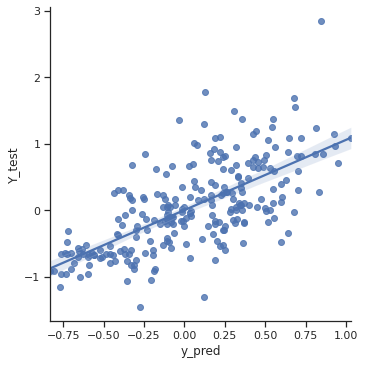

1
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
250
2-fold :  49.2
3-fold :  70.0
5-fold :  84.0
gmfe :  2.323032550549759
mfe :  1.3654101623098267
bias :  0.07730777786032839
rmse  0.46431285150614565
r2  0.422551473288869
saving model


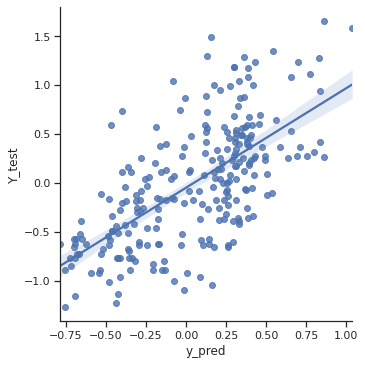

2
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=8,
                      n_jobs=30, random_state=42)
Calculating Permutation Importances
250
2-fold :  53.6
3-fold :  69.6
5-fold :  81.6
gmfe :  2.4440498153887638
mfe :  1.3085166447131702
bias :  0.004116982094910709
rmse  0.5244413163807657
r2  0.3668189996979443


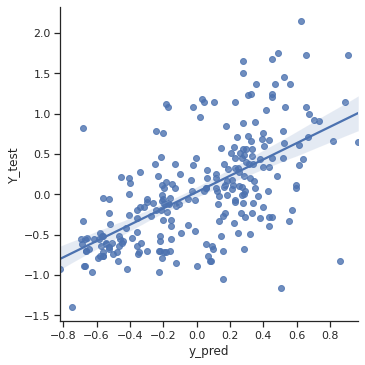

3
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=42)
Calculating Permutation Importances
250
2-fold :  54.0
3-fold :  69.6
5-fold :  87.6
gmfe :  2.264952279517103
mfe :  1.3032286019916888
bias :  -0.0020974872763230012
rmse  0.4689369410515956
r2  0.474925419929757
saving model


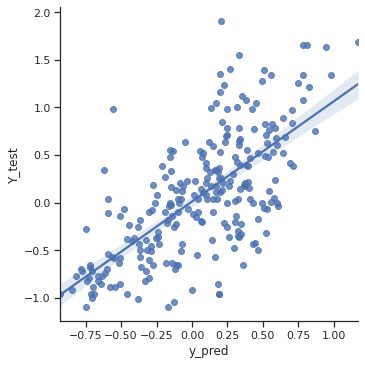

4
(1000, 9)
(249, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=42)
Calculating Permutation Importances
249
2-fold :  51.40562248995983
3-fold :  74.29718875502009
5-fold :  88.75502008032129
gmfe :  2.277078851375555
mfe :  1.3358385014633647
bias :  0.023638947408618327
rmse  0.46296412152419286
r2  0.4444734324637797


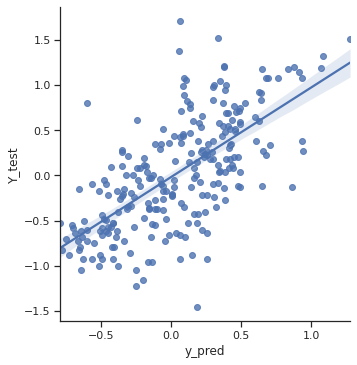

0
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
250
2-fold :  54.0
3-fold :  70.39999999999999
5-fold :  84.8
gmfe :  2.354550872988766
mfe :  1.3240328414377573
bias :  0.053898943848585346
rmse  0.47902009819262525
r2  0.3718257702973571


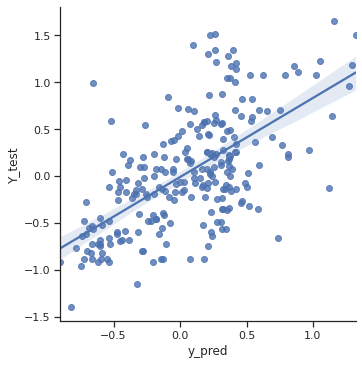

1
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=43)
Calculating Permutation Importances
250
2-fold :  48.4
3-fold :  67.2
5-fold :  83.2
gmfe :  2.4764102108558967
mfe :  1.356023659917151
bias :  0.007139411225724077
rmse  0.5104150499258644
r2  0.4335095201608612


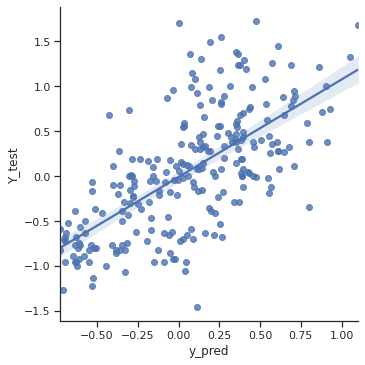

2
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=43)
Calculating Permutation Importances
250
2-fold :  54.0
3-fold :  74.0
5-fold :  87.6
gmfe :  2.2554146825095063
mfe :  1.3122681838704946
bias :  0.011841158842577804
rmse  0.4735604847912717
r2  0.42898853524137537
saving model


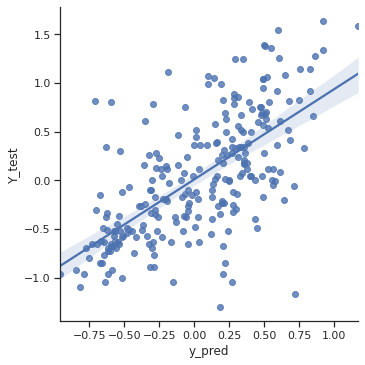

3
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=8,
                      n_jobs=30, random_state=43)
Calculating Permutation Importances
250
2-fold :  53.6
3-fold :  71.6
5-fold :  87.2
gmfe :  2.2379686574149504
mfe :  1.3216246963086433
bias :  0.014306172624383107
rmse  0.4694147984521748
r2  0.4568051566935364
saving model


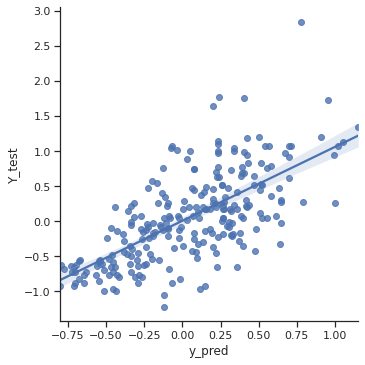

4
(1000, 9)
(249, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
249
2-fold :  53.41365461847389
3-fold :  71.8875502008032
5-fold :  86.74698795180723
gmfe :  2.2839971300715507
mfe :  1.307987692652
bias :  0.01311222688287228
rmse  0.4825080801320266
r2  0.44674619009327976


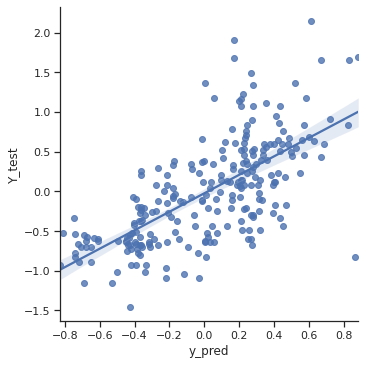

0
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_jobs=30, random_state=44)
Calculating Permutation Importances
250
2-fold :  52.800000000000004
3-fold :  69.6
5-fold :  84.0
gmfe :  2.3792307880976122
mfe :  1.2935409169285368
bias :  0.018161618559359605
rmse  0.5080671900362561
r2  0.36930927988023465


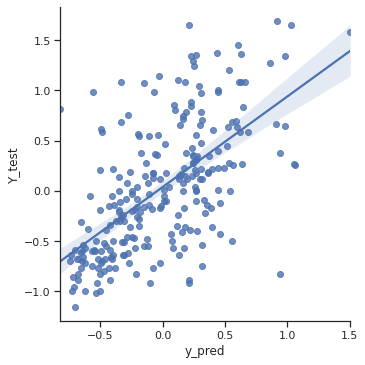

1
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=8,
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
250
2-fold :  47.199999999999996
3-fold :  69.19999999999999
5-fold :  84.8
gmfe :  2.423622841665768
mfe :  1.379633239235266
bias :  0.035649069503228985
rmse  0.49841661522241076
r2  0.45179703039652774


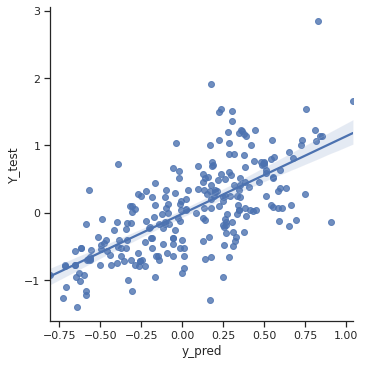

2
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=4,
                      n_jobs=30, random_state=44)
Calculating Permutation Importances
250
2-fold :  52.0
3-fold :  68.8
5-fold :  82.8
gmfe :  2.3736735537792617
mfe :  1.316361048997575
bias :  0.04173059050101288
rmse  0.4931398286694
r2  0.41797335646917055


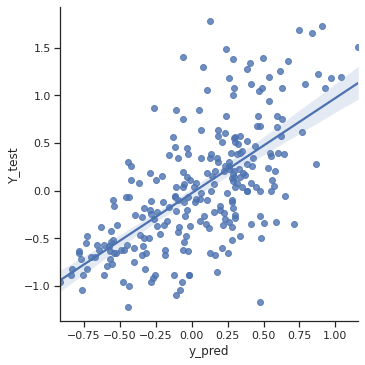

3
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
250
2-fold :  54.800000000000004
3-fold :  77.2
5-fold :  89.2
gmfe :  2.17560760811968
mfe :  1.2897238539216138
bias :  0.05026361988855298
rmse  0.44599979546209895
r2  0.45389381569212994
saving model


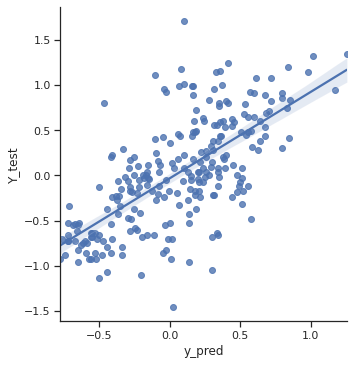

4
(1000, 9)
(249, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=200,
                      n_jobs=30, random_state=44)
Calculating Permutation Importances
249
2-fold :  53.81526104417671
3-fold :  75.90361445783132
5-fold :  89.5582329317269
gmfe :  2.1877321309521665
mfe :  1.3211027379628488
bias :  0.014949673594818247
rmse  0.4502397559458677
r2  0.4952050300260872


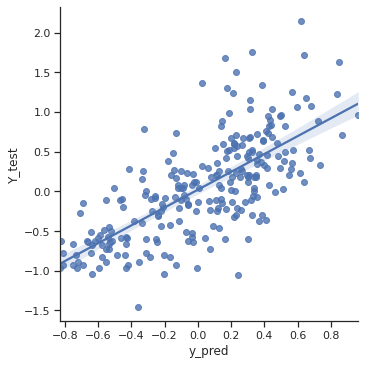

0
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=45)
Calculating Permutation Importances
250
2-fold :  52.0
3-fold :  70.8
5-fold :  84.39999999999999
gmfe :  2.3560984903585442
mfe :  1.3313952214823175
bias :  0.004846159530093597
rmse  0.5017994122382755
r2  0.3915544382668341


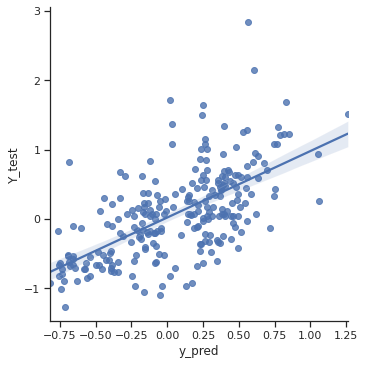

1
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', n_estimators=300,
                      n_jobs=30, random_state=45)
Calculating Permutation Importances
250
2-fold :  56.8
3-fold :  74.4
5-fold :  86.0
gmfe :  2.1814506425028264
mfe :  1.2849133757365978
bias :  0.009075596102629369
rmse  0.45247563289176057
r2  0.41982291717907283


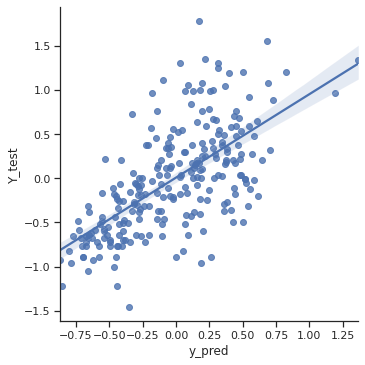

2
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=45)
Calculating Permutation Importances
250
2-fold :  49.2
3-fold :  69.6
5-fold :  85.2
gmfe :  2.461311581451269
mfe :  1.3721971891008924
bias :  -0.011584693793181791
rmse  0.5181091081862224
r2  0.41218827094342536


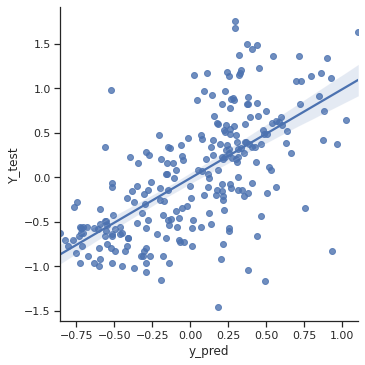

3
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
250
2-fold :  48.8
3-fold :  69.19999999999999
5-fold :  86.4
gmfe :  2.3357859327308197
mfe :  1.362375529617952
bias :  0.0870459162015392
rmse  0.47500506983582136
r2  0.42748215950709145


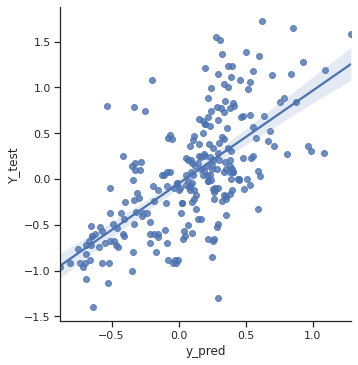

4
(1000, 9)
(249, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=45)
Calculating Permutation Importances
249
2-fold :  53.41365461847389
3-fold :  75.1004016064257
5-fold :  87.14859437751004
gmfe :  2.238786674526406
mfe :  1.3304240876704039
bias :  -0.005031108473535745
rmse  0.4541360081190252
r2  0.512919989272949


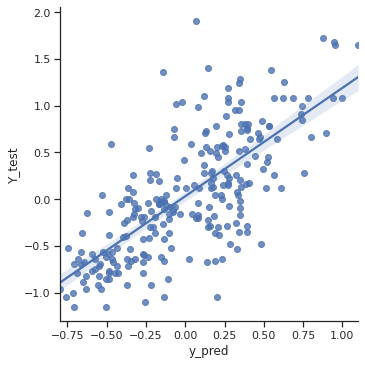

0
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
250
2-fold :  50.0
3-fold :  73.6
5-fold :  87.6
gmfe :  2.305995068298016
mfe :  1.3505786827170403
bias :  0.02638137361565407
rmse  0.46631763912525326
r2  0.442902712607288


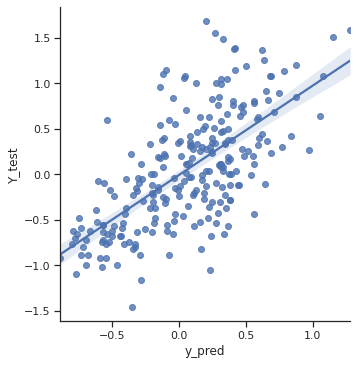

1
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=8,
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
250
2-fold :  51.6
3-fold :  74.0
5-fold :  87.2
gmfe :  2.312510600825689
mfe :  1.333016577759196
bias :  0.032093793860942826
rmse  0.48124795481018123
r2  0.4531167346177978


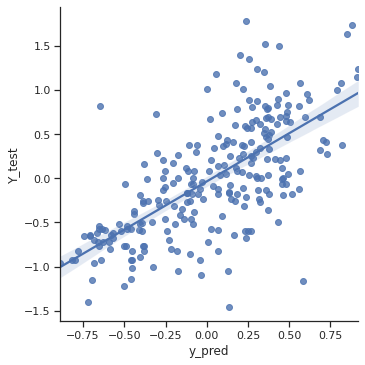

2
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=8, n_jobs=30, random_state=46)
Calculating Permutation Importances
250
2-fold :  53.6
3-fold :  71.6
5-fold :  84.39999999999999
gmfe :  2.352827337038082
mfe :  1.3269708169182997
bias :  -0.023373978099091433
rmse  0.4864018602023641
r2  0.41676627126826604


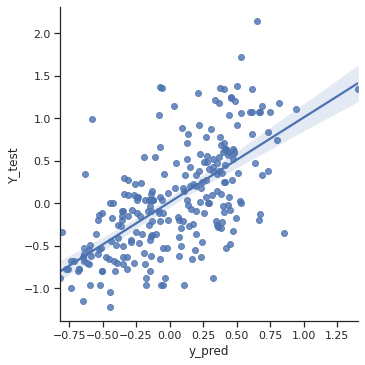

3
(999, 9)
(250, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,
                      n_jobs=30, random_state=46)
Calculating Permutation Importances
250
2-fold :  56.00000000000001
3-fold :  72.0
5-fold :  87.2
gmfe :  2.2698349445320383
mfe :  1.3000843492386627
bias :  -0.0399728773793593
rmse  0.47526381635481635
r2  0.46745952351727094


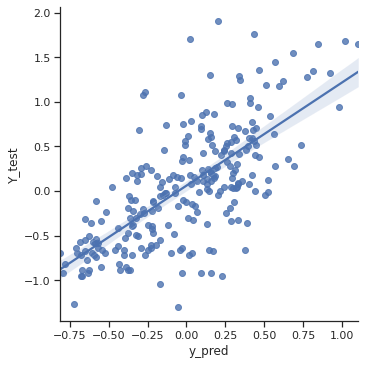

4
(1000, 9)
(249, 9)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=8,
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
249
2-fold :  50.20080321285141
3-fold :  68.27309236947792
5-fold :  85.54216867469879
gmfe :  2.340936410503021
mfe :  1.3453094665361762
bias :  0.05284735640910618
rmse  0.49083165043924765
r2  0.3990930821155496


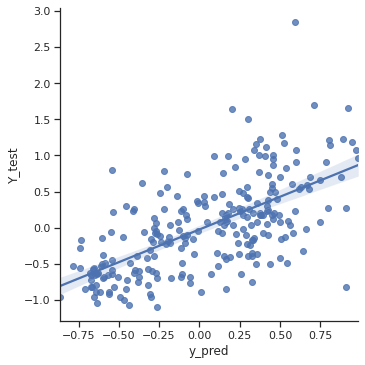

human_CL_mL_min_kg
0
(1024, 9)
(257, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=8,
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
257
2-fold :  47.081712062256805
3-fold :  68.48249027237354
5-fold :  84.04669260700389
gmfe :  2.6652357185406776
mfe :  1.3811255991976283
bias :  -0.3195657228482851
rmse  0.5859469541444606
r2  0.2471701851192829
saving model


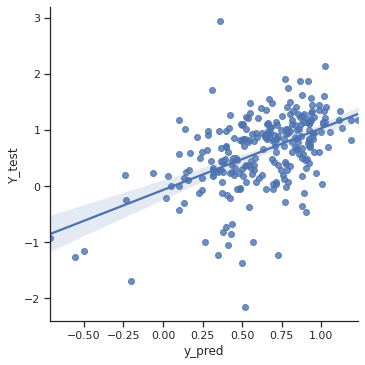

1
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=4,
                      n_jobs=30, random_state=42)
Calculating Permutation Importances
256
2-fold :  43.75
3-fold :  66.40625
5-fold :  84.375
gmfe :  2.611537331290955
mfe :  1.4071992771944408
bias :  -0.7416961548836769
rmse  0.5461579516553944
r2  0.2657374366031625
saving model


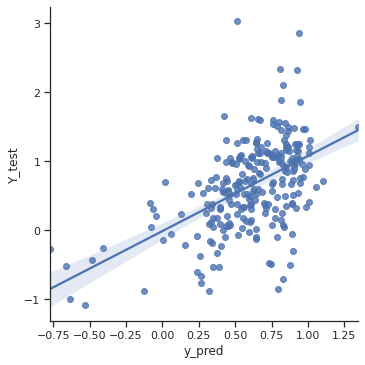

2
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=42)
Calculating Permutation Importances
256
2-fold :  50.390625
3-fold :  69.53125
5-fold :  82.421875
gmfe :  2.556865872515983
mfe :  1.3467016090682515
bias :  -0.16963007962686488
rmse  0.5575867857354416
r2  0.13863656536355096
saving model


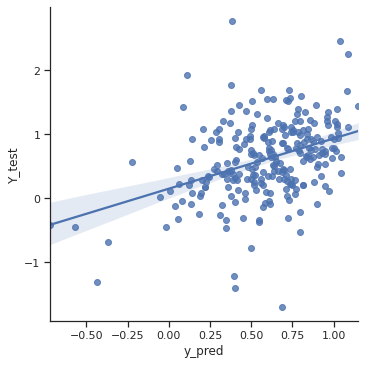

3
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=42)
Calculating Permutation Importances
256
2-fold :  46.875
3-fold :  70.3125
5-fold :  83.59375
gmfe :  2.6550311730088696
mfe :  1.378689321259154
bias :  -0.4792960891605602
rmse  0.578516814843795
r2  0.2264389866506995


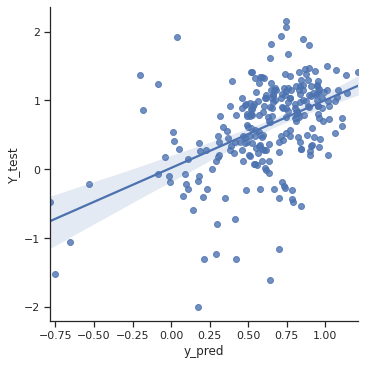

4
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='log2', n_estimators=300,
                      n_jobs=30, random_state=42)
Calculating Permutation Importances
256
2-fold :  45.703125
3-fold :  65.625
5-fold :  79.296875
gmfe :  2.83513245564345
mfe :  1.4043810176348661
bias :  0.35866837912803584
rmse  0.6167279136140613
r2  0.15030112921677663


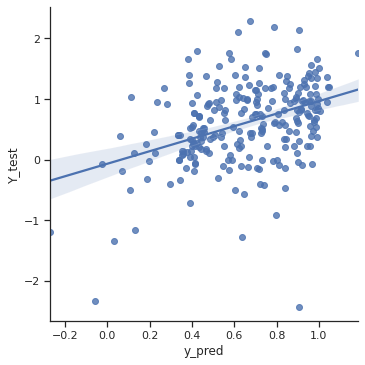

0
(1024, 9)
(257, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,
                      n_jobs=30, random_state=43)
Calculating Permutation Importances
257
2-fold :  46.69260700389105
3-fold :  63.42412451361867
5-fold :  76.65369649805449
gmfe :  2.955434105343985
mfe :  1.3769748337813732
bias :  0.17930237582995634
rmse  0.6529723348182992
r2  0.15894924928256104


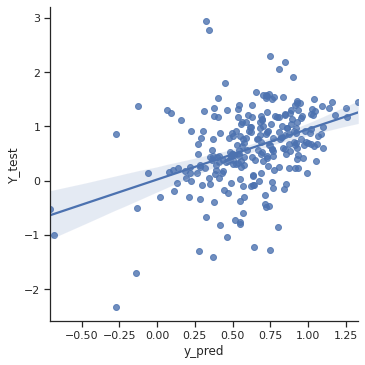

1
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='log2', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
256
2-fold :  40.625
3-fold :  62.5
5-fold :  80.46875
gmfe :  2.9547489577535426
mfe :  1.4429100898264327
bias :  -0.4160509661832049
rmse  0.6370089615232157
r2  0.18917732220018135


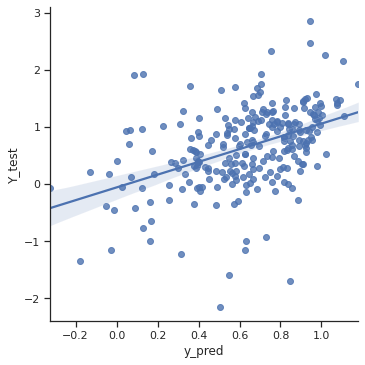

2
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=43)
Calculating Permutation Importances
256
2-fold :  46.484375
3-fold :  66.40625
5-fold :  82.421875
gmfe :  2.584069371340518
mfe :  1.3921437582875726
bias :  -0.33492477050935465
rmse  0.5414596365417338
r2  0.1886656085397972


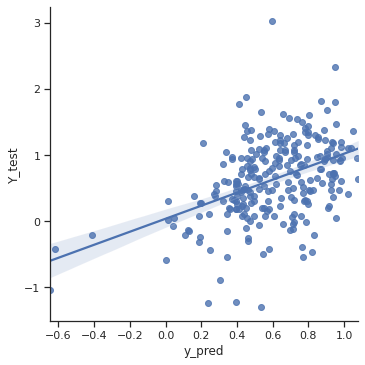

3
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=8,
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
256
2-fold :  49.21875
3-fold :  69.53125
5-fold :  86.328125
gmfe :  2.4672649830102062
mfe :  1.3600864206486658
bias :  -0.29760662152730283
rmse  0.5177150327552333
r2  0.264349568626988
saving model


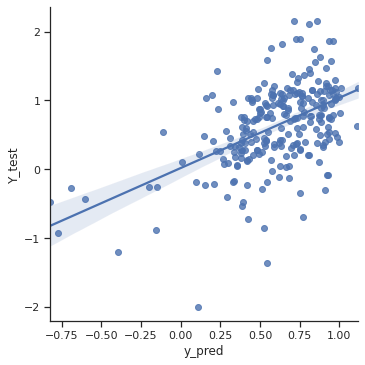

4
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', min_samples_split=8,
                      n_jobs=30, random_state=43)
Calculating Permutation Importances
256
2-fold :  47.265625
3-fold :  71.484375
5-fold :  84.765625
gmfe :  2.4599430808996487
mfe :  1.3677732949562873
bias :  -0.16032563933735444
rmse  0.5216897336669986
r2  0.264376618399078
saving model


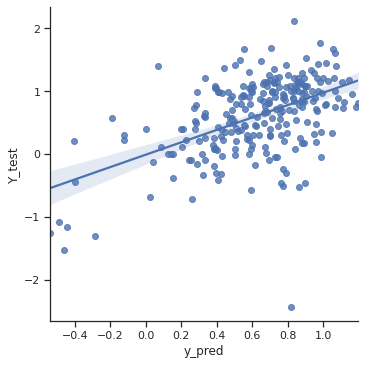

0
(1024, 9)
(257, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=8,
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
257
2-fold :  50.97276264591439
3-fold :  66.9260700389105
5-fold :  84.43579766536965
gmfe :  2.556389186082387
mfe :  1.343143905883321
bias :  -0.08137691442441763
rmse  0.5432871305564017
r2  0.26985607000520184


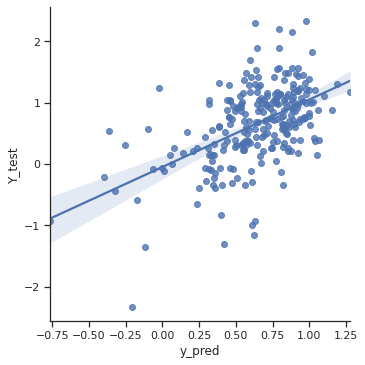

1
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
256
2-fold :  53.90625
3-fold :  73.046875
5-fold :  82.8125
gmfe :  2.476259958322843
mfe :  1.3303163385287786
bias :  -0.49680565526295395
rmse  0.5537199452942179
r2  0.22254173658741772


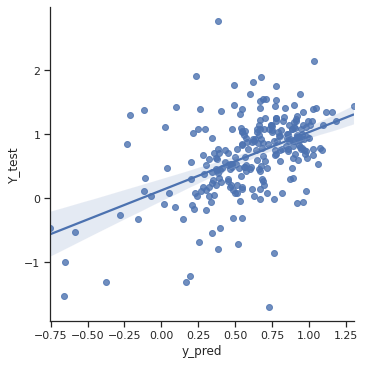

2
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=8,
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
256
2-fold :  42.578125
3-fold :  66.40625
5-fold :  81.640625
gmfe :  2.7986435016951665
mfe :  1.4114882919812743
bias :  0.22136592061353966
rmse  0.6013677902229295
r2  0.20045110911782638


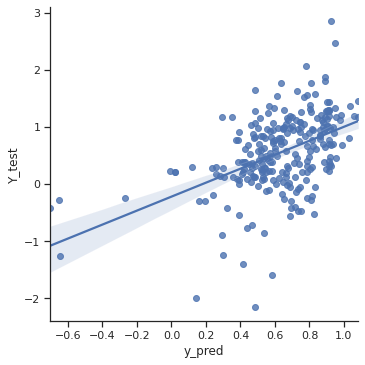

3
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='log2', n_estimators=300,
                      n_jobs=30, random_state=44)
Calculating Permutation Importances
256
2-fold :  42.578125
3-fold :  67.578125
5-fold :  83.984375
gmfe :  2.7811245312538415
mfe :  1.4123863449357101
bias :  -0.13573540631530479
rmse  0.6174943271408018
r2  0.16704190385733886


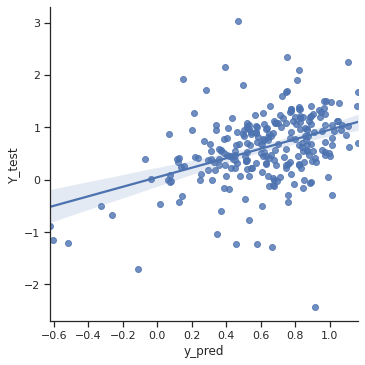

4
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='log2', n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
256
2-fold :  46.484375
3-fold :  69.921875
5-fold :  82.8125
gmfe :  2.547198608460226
mfe :  1.3740723184716845
bias :  -0.3513173464767191
rmse  0.5392393638947489
r2  0.2507656899104178


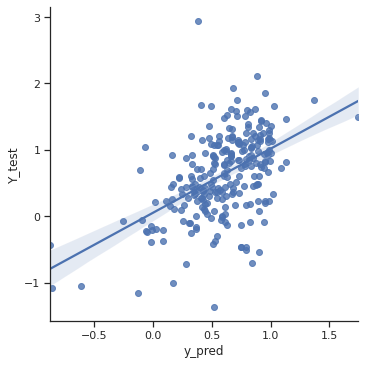

0
(1024, 9)
(257, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=45)
Calculating Permutation Importances
257
2-fold :  51.36186770428015
3-fold :  70.8171206225681
5-fold :  86.7704280155642
gmfe :  2.3741753929481004
mfe :  1.32736411007887
bias :  -0.6626437194080737
rmse  0.4721491124847124
r2  0.33071022246496495
saving model


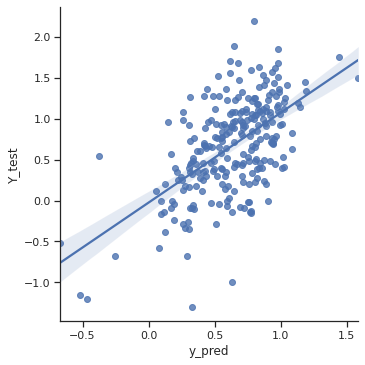

1
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
Calculating Permutation Importances
256
2-fold :  51.171875
3-fold :  69.53125
5-fold :  83.59375
gmfe :  2.5567654873997583
mfe :  1.3460477288332144
bias :  0.17854414092604465
rmse  0.5406712300227259
r2  0.2163827619993104


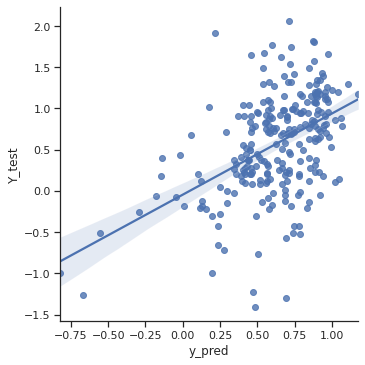

2
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=8,
                      n_jobs=30, random_state=45)
Calculating Permutation Importances
256
2-fold :  42.1875
3-fold :  67.1875
5-fold :  81.25
gmfe :  2.7602496966478913
mfe :  1.4117340319851324
bias :  -0.7160191809513955
rmse  0.6130482809217299
r2  0.1548199319733501


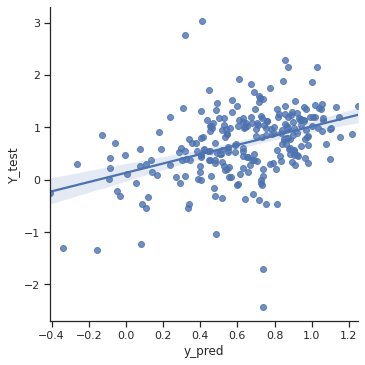

3
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_jobs=30, random_state=45)
Calculating Permutation Importances
256
2-fold :  47.265625
3-fold :  67.1875
5-fold :  82.421875
gmfe :  2.6309196250287075
mfe :  1.3666692820341777
bias :  0.24354029558457113
rmse  0.5812404049959492
r2  0.17543987040147924


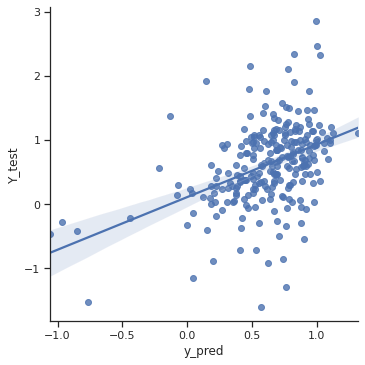

4
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=45)
Calculating Permutation Importances
256
2-fold :  44.921875
3-fold :  66.796875
5-fold :  80.46875
gmfe :  2.902381136803487
mfe :  1.388989714238077
bias :  0.09367588258389178
rmse  0.6420882174332896
r2  0.22580995790025493


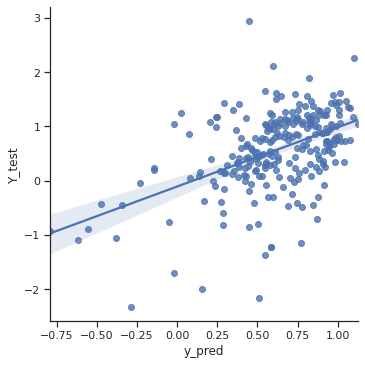

0
(1024, 9)
(257, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', min_samples_split=8,
                      n_estimators=200, n_jobs=30, random_state=46)
Calculating Permutation Importances
257
2-fold :  52.14007782101168
3-fold :  70.03891050583657
5-fold :  83.26848249027238
gmfe :  2.507891564504305
mfe :  1.3205817464905814
bias :  -0.9745730851734038
rmse  0.5674994677362075
r2  0.20027044447433173


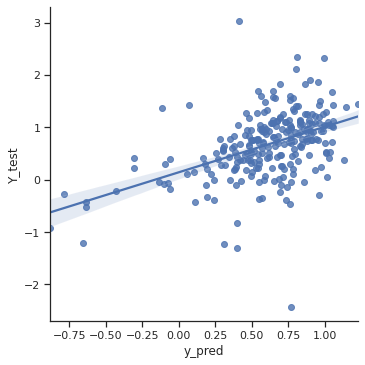

1
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=8,
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
256
2-fold :  41.796875
3-fold :  65.234375
5-fold :  79.296875
gmfe :  2.9165587238912822
mfe :  1.410412653585358
bias :  -0.4582925987211206
rmse  0.625868563754123
r2  0.2362961486384456


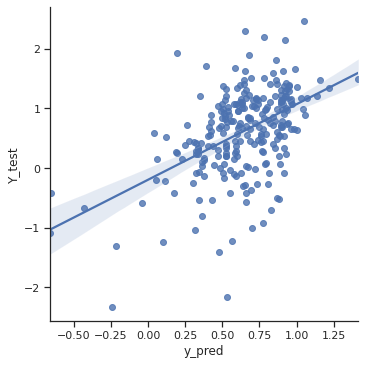

2
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
256
2-fold :  49.609375
3-fold :  64.453125
5-fold :  80.859375
gmfe :  2.733434813492518
mfe :  1.3753381337569506
bias :  0.2119696587221231
rmse  0.6044486608625783
r2  0.1684317873946537


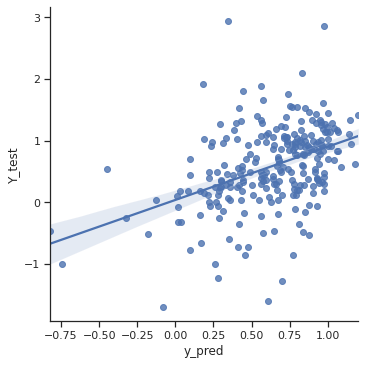

3
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=46)
Calculating Permutation Importances
256
2-fold :  43.359375
3-fold :  67.578125
5-fold :  83.203125
gmfe :  2.7106503844947976
mfe :  1.4226431163038589
bias :  -0.2893267656759044
rmse  0.5704485630066359
r2  0.22013006247194777


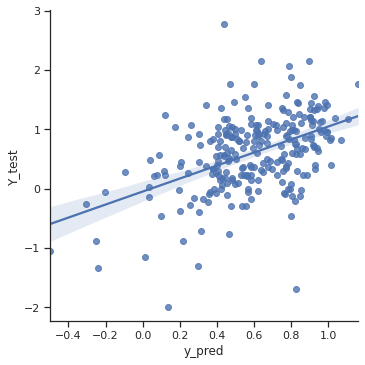

4
(1025, 9)
(256, 9)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=46)
Calculating Permutation Importances
256
2-fold :  51.5625
3-fold :  73.828125
5-fold :  85.15625
gmfe :  2.3512335867573486
mfe :  1.3422835179757255
bias :  -0.11400182865037056
rmse  0.48836864248540296
r2  0.27245910865015266
saving model


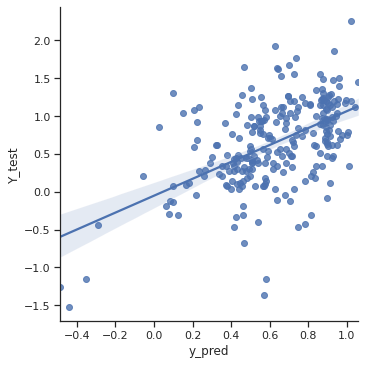

human_fup
0
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,
                      n_jobs=30, random_state=42)
Calculating Permutation Importances
176
2-fold :  52.84090909090909
3-fold :  63.63636363636363
5-fold :  77.8409090909091
gmfe :  3.053115010526972
mfe :  1.307159947244361
bias :  0.040210368986073455
rmse  0.2204814115198092
r2  0.6060351685969958
saving model


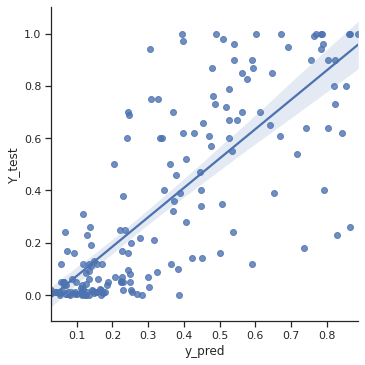

1
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
176
2-fold :  56.81818181818182
3-fold :  72.72727272727273
5-fold :  78.97727272727273
gmfe :  2.7433343722880945
mfe :  1.2972307955040108
bias :  0.04502863639349155
rmse  0.2105994123845999
r2  0.5622794619578402
saving model


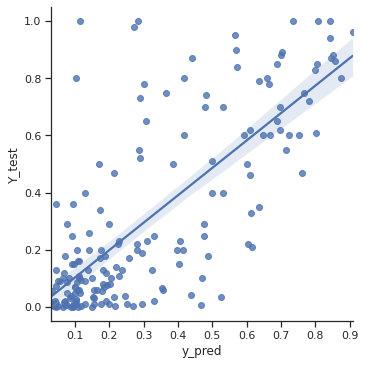

2
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=8,
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
176
2-fold :  57.95454545454546
3-fold :  70.45454545454545
5-fold :  82.95454545454545
gmfe :  2.534903655463005
mfe :  1.2465398319429895
bias :  0.013439463496291753
rmse  0.24996243924331757
r2  0.4799719231615154
saving model


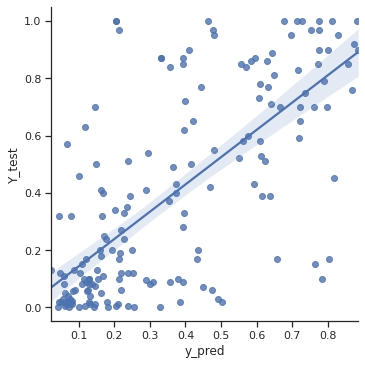

3
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=42)
Calculating Permutation Importances
176
2-fold :  54.54545454545454
3-fold :  65.9090909090909
5-fold :  79.54545454545455
gmfe :  2.7194250486985228
mfe :  1.2916047767209873
bias :  0.04066553190157135
rmse  0.2253429039258107
r2  0.5765784711031983


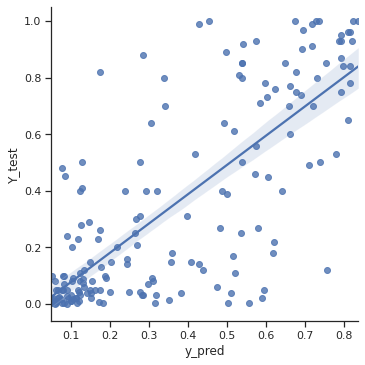

4
(704, 9)
(175, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
175
2-fold :  54.85714285714286
3-fold :  65.14285714285715
5-fold :  76.0
gmfe :  2.724288629055759
mfe :  1.2840827003830444
bias :  0.03447657315576121
rmse  0.21096597865465352
r2  0.6055053736706869


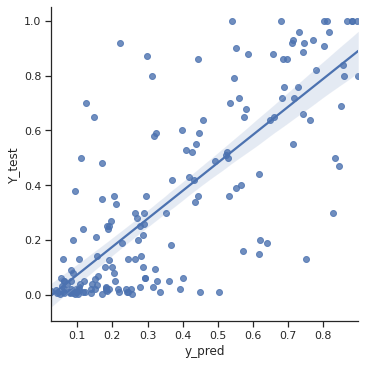

0
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
176
2-fold :  54.54545454545454
3-fold :  68.18181818181817
5-fold :  79.54545454545455
gmfe :  2.652109820842254
mfe :  1.2909027120537029
bias :  0.03937075263954715
rmse  0.2154349901431489
r2  0.5956978025296572


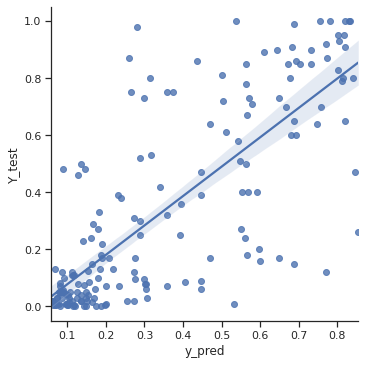

1
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_jobs=30, random_state=43)
Calculating Permutation Importances
176
2-fold :  58.52272727272727
3-fold :  68.18181818181817
5-fold :  77.8409090909091
gmfe :  2.8899731619097815
mfe :  1.2735697096899128
bias :  0.04301945808633006
rmse  0.21931256507815336
r2  0.5338483568898165


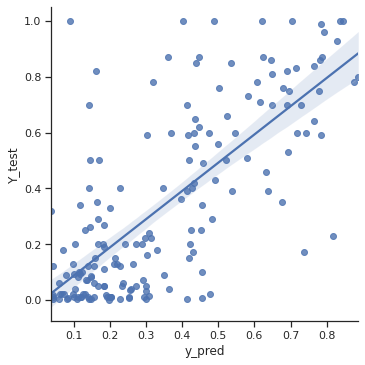

2
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=43)
Calculating Permutation Importances
176
2-fold :  54.54545454545454
3-fold :  66.47727272727273
5-fold :  76.13636363636364
gmfe :  2.97840686824627
mfe :  1.3073507894860124
bias :  0.03627058694369038
rmse  0.2300523125406865
r2  0.6119129061998614


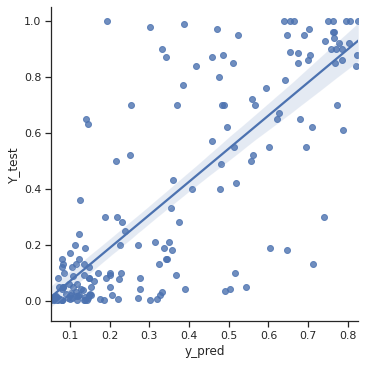

3
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=8,
                      n_jobs=30, random_state=43)
Calculating Permutation Importances
176
2-fold :  50.56818181818182
3-fold :  65.9090909090909
5-fold :  77.27272727272727
gmfe :  3.056659672369864
mfe :  1.329046562446671
bias :  0.020197766197172128
rmse  0.2550444113770994
r2  0.48720491830550827


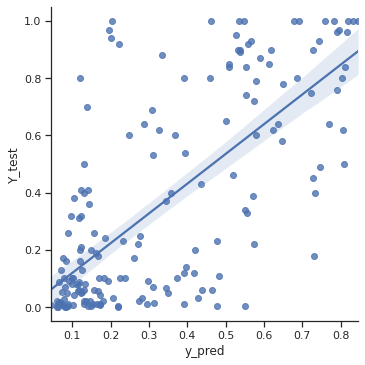

4
(704, 9)
(175, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
175
2-fold :  52.0
3-fold :  69.14285714285714
5-fold :  81.14285714285714
gmfe :  2.485487577588562
mfe :  1.305173859487046
bias :  0.04862122333759877
rmse  0.19639348649148802
r2  0.6059997118117117
saving model


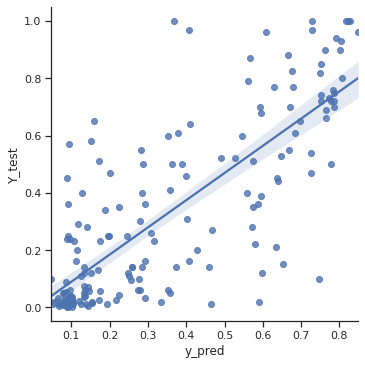

0
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,
                      n_jobs=30, random_state=44)
Calculating Permutation Importances
176
2-fold :  58.52272727272727
3-fold :  69.88636363636364
5-fold :  81.81818181818183
gmfe :  2.4437722975607317
mfe :  1.2423417005752089
bias :  0.037749806094092675
rmse  0.2148090747441342
r2  0.6215523410126811
saving model


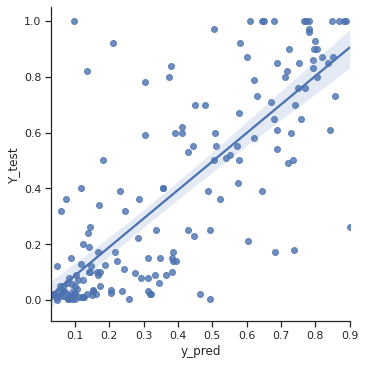

1
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
176
2-fold :  52.27272727272727
3-fold :  63.63636363636363
5-fold :  77.27272727272727
gmfe :  2.7913207332796555
mfe :  1.311405290392578
bias :  0.03623521858872738
rmse  0.22486204582105987
r2  0.5372969837674988


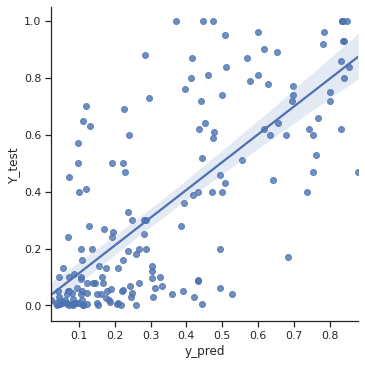

2
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
176
2-fold :  56.25
3-fold :  67.04545454545455
5-fold :  76.70454545454545
gmfe :  2.9601173228756776
mfe :  1.2773274753503432
bias :  0.02653349821428569
rmse  0.2296983580796555
r2  0.5408584621915599


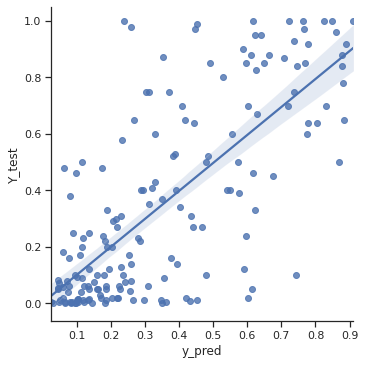

3
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=44)
Calculating Permutation Importances
176
2-fold :  56.81818181818182
3-fold :  69.31818181818183
5-fold :  78.4090909090909
gmfe :  2.841969191947236
mfe :  1.252893221303123
bias :  0.03362310708316785
rmse  0.22865745378063412
r2  0.5786111688056761


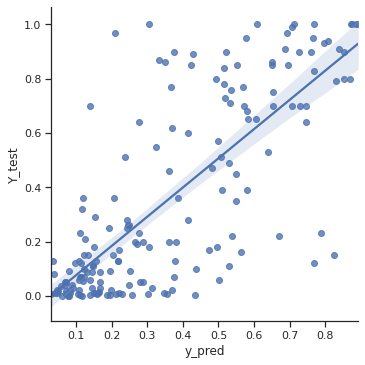

4
(704, 9)
(175, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=44)
Calculating Permutation Importances
175
2-fold :  52.57142857142857
3-fold :  66.28571428571428
5-fold :  74.28571428571429
gmfe :  2.7490437178055704
mfe :  1.3054140564308865
bias :  0.05220632884973722
rmse  0.20994043920444871
r2  0.5953841132525548


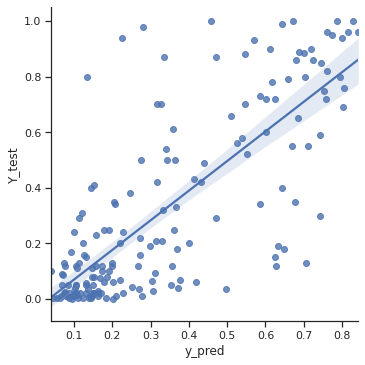

0
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
176
2-fold :  48.29545454545455
3-fold :  65.3409090909091
5-fold :  74.43181818181817
gmfe :  3.1618495771285122
mfe :  1.3713134925647732
bias :  0.06252196886392038
rmse  0.22734869722137918
r2  0.44759473614438094


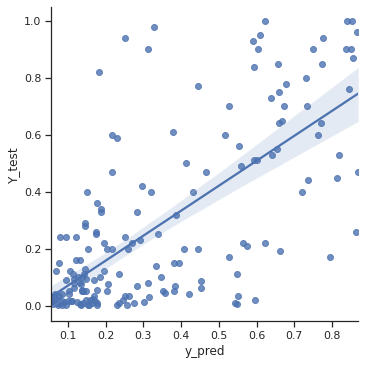

1
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=45)
Calculating Permutation Importances
176
2-fold :  54.54545454545454
3-fold :  66.47727272727273
5-fold :  78.4090909090909
gmfe :  2.6317367056829766
mfe :  1.2919943311925464
bias :  0.02360932883442552
rmse  0.24135995381595382
r2  0.49659420909805596


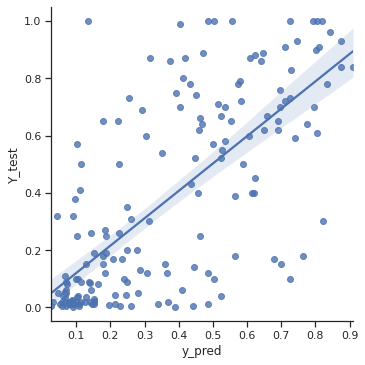

2
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=4,
                      n_jobs=30, random_state=45)
Calculating Permutation Importances
176
2-fold :  57.95454545454546
3-fold :  68.18181818181817
5-fold :  78.97727272727273
gmfe :  2.7049702774267876
mfe :  1.2806152733425675
bias :  0.031018270272490777
rmse  0.2153649740115137
r2  0.6332175737746911


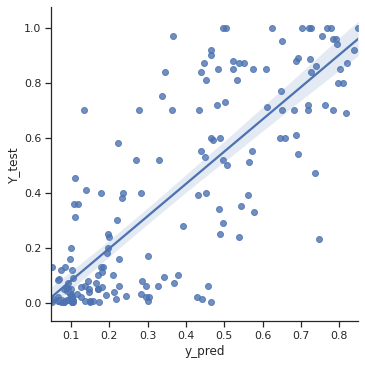

3
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=4,
                      n_jobs=30, random_state=45)
Calculating Permutation Importances
176
2-fold :  54.54545454545454
3-fold :  67.61363636363636
5-fold :  78.4090909090909
gmfe :  2.681333546931671
mfe :  1.2763586951605421
bias :  0.04095133694822509
rmse  0.22627839733497962
r2  0.549771583817929


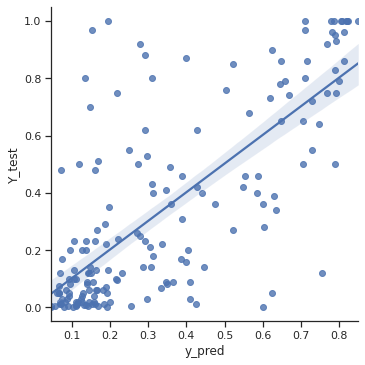

4
(704, 9)
(175, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
175
2-fold :  60.57142857142858
3-fold :  71.42857142857143
5-fold :  79.42857142857143
gmfe :  2.746346522071466
mfe :  1.2808381343225264
bias :  0.029900705245226922
rmse  0.2227188683907974
r2  0.6012383037271812


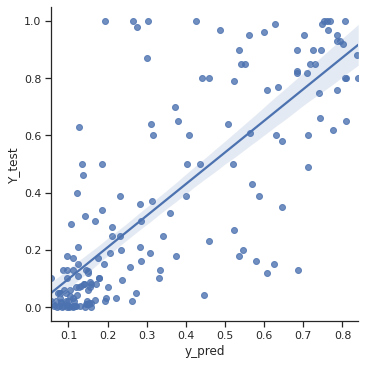

0
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=46)
Calculating Permutation Importances
176
2-fold :  52.27272727272727
3-fold :  65.9090909090909
5-fold :  77.27272727272727
gmfe :  2.9911571687291754
mfe :  1.3171949478019929
bias :  0.05004121595079593
rmse  0.2238634054178716
r2  0.5903473068769667


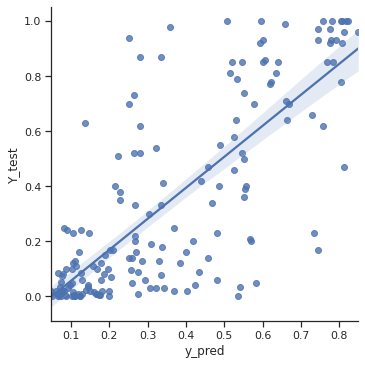

1
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
176
2-fold :  55.68181818181818
3-fold :  72.1590909090909
5-fold :  82.95454545454545
gmfe :  2.5993154600622255
mfe :  1.24898582939886
bias :  0.025202612861646233
rmse  0.210618737782228
r2  0.597387929043961


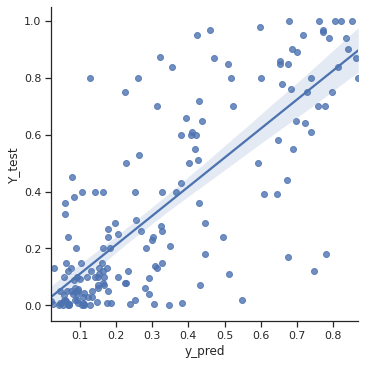

2
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_jobs=30, random_state=46)
Calculating Permutation Importances
176
2-fold :  50.0
3-fold :  63.06818181818182
5-fold :  75.0
gmfe :  2.912383484284479
mfe :  1.3495877905100224
bias :  0.03565896537588277
rmse  0.2491657862277517
r2  0.48192882978269325


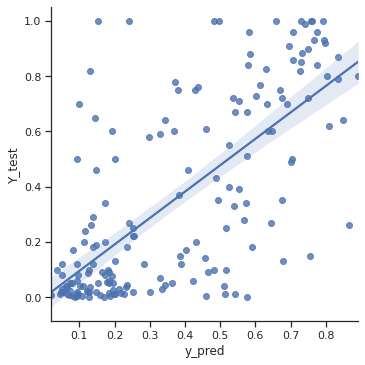

3
(703, 9)
(176, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=46)
Calculating Permutation Importances
176
2-fold :  64.77272727272727
3-fold :  72.1590909090909
5-fold :  80.11363636363636
gmfe :  2.609595063850925
mfe :  1.2349531881220348
bias :  0.027803870206878877
rmse  0.19889586102312307
r2  0.6336635516214291


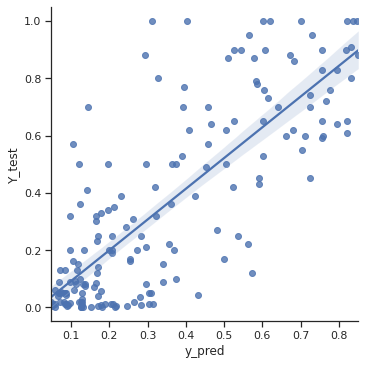

4
(704, 9)
(175, 9)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=8,
                      n_jobs=30, random_state=46)
Calculating Permutation Importances
175
2-fold :  50.28571428571429
3-fold :  68.0
5-fold :  76.57142857142857
gmfe :  2.6320089270283606
mfe :  1.3446764162032632
bias :  0.042328255168512616
rmse  0.23599970659558037
r2  0.5364835960734016


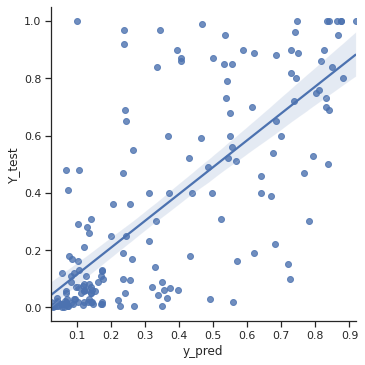

human_mrt
0
(994, 9)
(249, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=42)
Calculating Permutation Importances
249
2-fold :  40.963855421686745
3-fold :  63.85542168674698
5-fold :  82.32931726907631
gmfe :  2.729174386092814
mfe :  1.4102917594729112
bias :  0.26227413521151044
rmse  0.5534484859948795
r2  0.20391658553227687
saving model


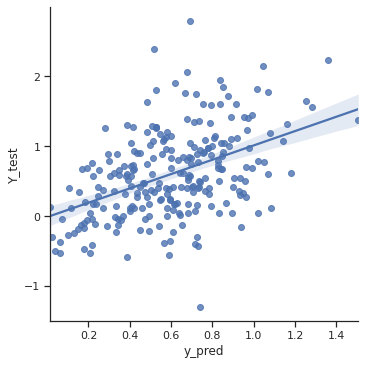

1
(994, 9)
(249, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=42)
Calculating Permutation Importances
249
2-fold :  51.80722891566265
3-fold :  69.47791164658635
5-fold :  84.33734939759037
gmfe :  2.58091256729958
mfe :  1.3241232166079526
bias :  -0.5039772348689486
rmse  0.5588528618356629
r2  0.13981120620107268
saving model


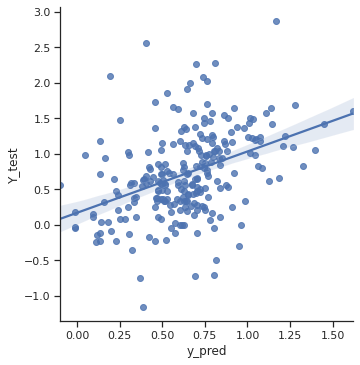

2
(994, 9)
(249, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
249
2-fold :  42.971887550200805
3-fold :  65.06024096385542
5-fold :  81.52610441767068
gmfe :  2.869945971381716
mfe :  1.4105041462077952
bias :  -0.044822095377918814
rmse  0.6112392934244372
r2  0.14699393608215772


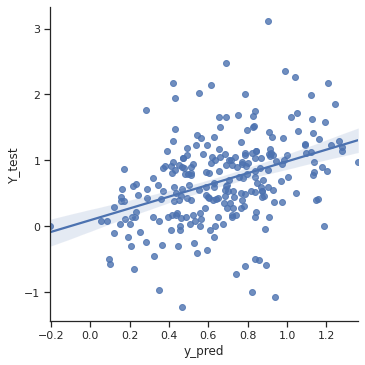

3
(995, 9)
(248, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='log2', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=42)
Calculating Permutation Importances
248
2-fold :  45.564516129032256
3-fold :  62.903225806451616
5-fold :  78.2258064516129
gmfe :  2.8353900439425366
mfe :  1.3990233673831092
bias :  0.17957655126509509
rmse  0.6207329525597649
r2  0.19687023351576116


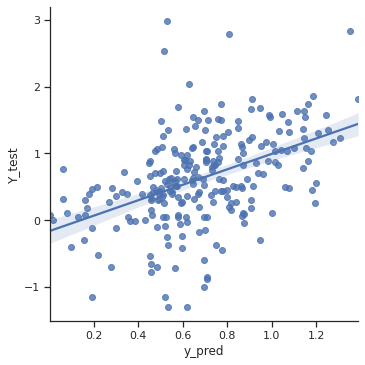

4
(995, 9)
(248, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
248
2-fold :  46.37096774193548
3-fold :  65.7258064516129
5-fold :  79.83870967741935
gmfe :  2.655208454491737
mfe :  1.3884241792691754
bias :  0.5711689304781024
rmse  0.5608498360199609
r2  0.17238061329554477


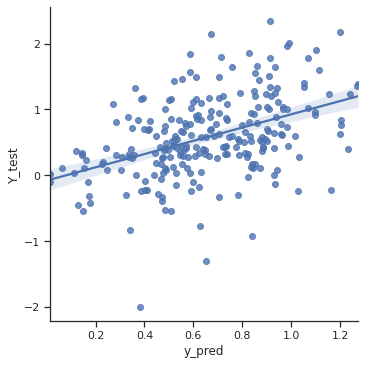

0
(994, 9)
(249, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='log2', n_estimators=200,
                      n_jobs=30, random_state=43)
Calculating Permutation Importances
249
2-fold :  42.971887550200805
3-fold :  65.06024096385542
5-fold :  83.93574297188755
gmfe :  2.7350524649348107
mfe :  1.4048162709578795
bias :  -0.19515161831501615
rmse  0.5750487953769813
r2  0.19713466618528475


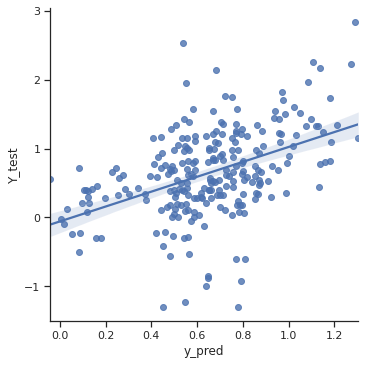

1
(994, 9)
(249, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', n_estimators=300,
                      n_jobs=30, random_state=43)
Calculating Permutation Importances
249
2-fold :  44.97991967871486
3-fold :  61.44578313253012
5-fold :  79.11646586345381
gmfe :  2.918191877621652
mfe :  1.4070756435678389
bias :  0.14327989181228995
rmse  0.6309446409565307
r2  0.17457557799874257


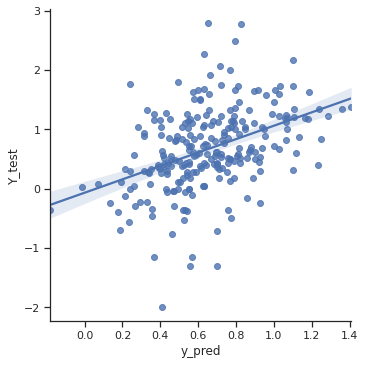

2
(994, 9)
(249, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=43)
Calculating Permutation Importances
249
2-fold :  45.78313253012048
3-fold :  65.46184738955823
5-fold :  83.53413654618474
gmfe :  2.5881911020180466
mfe :  1.3816500737555584
bias :  0.19515894763514385
rmse  0.5427096273848472
r2  0.21461806291016128


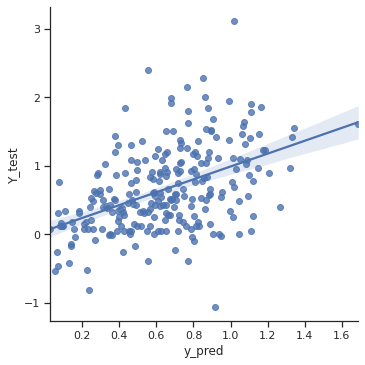

3
(995, 9)
(248, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=200,
                      n_jobs=30, random_state=43)
Calculating Permutation Importances
248
2-fold :  48.38709677419355
3-fold :  64.11290322580645
5-fold :  79.03225806451613
gmfe :  2.7861125713075072
mfe :  1.3711736437935926
bias :  -0.12626569246664232
rmse  0.6009788710469318
r2  0.16822473008162186


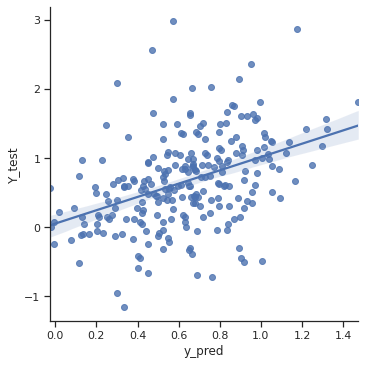

4
(995, 9)
(248, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', min_samples_split=8,
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
248
2-fold :  48.79032258064516
3-fold :  70.16129032258065
5-fold :  83.06451612903226
gmfe :  2.502128289743604
mfe :  1.3663761080949561
bias :  0.2646492514224277
rmse  0.5239312969602938
r2  0.22049162645387954
saving model


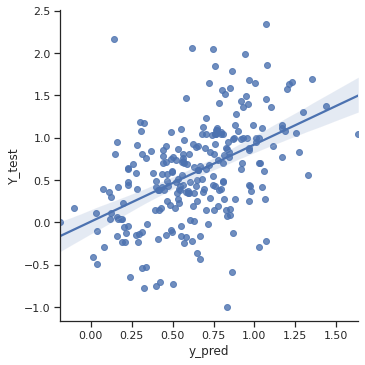

0
(994, 9)
(249, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', n_estimators=200,
                      n_jobs=30, random_state=44)
Calculating Permutation Importances
249
2-fold :  47.791164658634536
3-fold :  67.06827309236948
5-fold :  80.72289156626506
gmfe :  2.585259881192483
mfe :  1.3833856380964633
bias :  -0.043484887649782644
rmse  0.5478204681252946
r2  0.14731984889782257


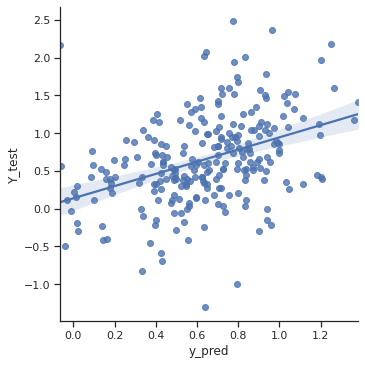

1
(994, 9)
(249, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
249
2-fold :  43.373493975903614
3-fold :  63.45381526104418
5-fold :  81.12449799196787
gmfe :  2.909168108843309
mfe :  1.4281525441056755
bias :  0.5050588211945451
rmse  0.6344078064116043
r2  0.16028433048047241


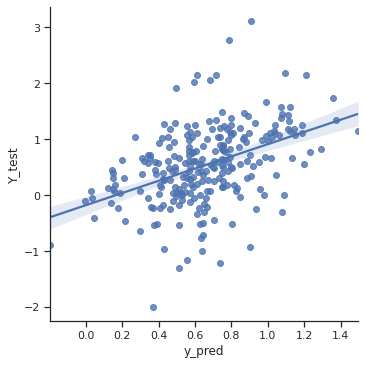

2
(994, 9)
(249, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=44)
Calculating Permutation Importances
249
2-fold :  46.58634538152611
3-fold :  65.86345381526104
5-fold :  81.92771084337349
gmfe :  2.6532546370572203
mfe :  1.4178674144091326
bias :  -0.06207537979570166
rmse  0.5580234730107438
r2  0.19617518466848038


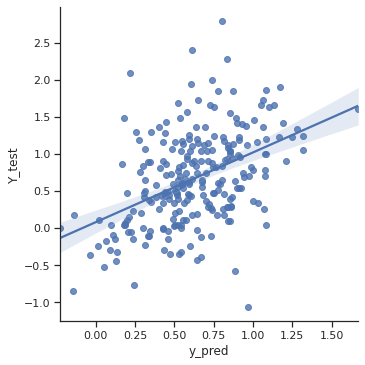

3
(995, 9)
(248, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=44)
Calculating Permutation Importances
248
2-fold :  47.17741935483871
3-fold :  68.95161290322581
5-fold :  81.85483870967742
gmfe :  2.6458917006611293
mfe :  1.3732523593513386
bias :  0.10643976894745477
rmse  0.5629705747646302
r2  0.19064974742780272


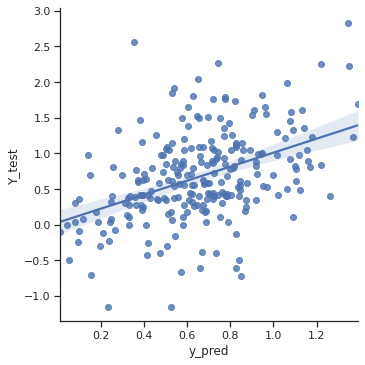

4
(995, 9)
(248, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='log2', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
248
2-fold :  43.145161290322584
3-fold :  63.306451612903224
5-fold :  79.43548387096774
gmfe :  2.7384722454613133
mfe :  1.4151192976252622
bias :  -0.24155671138064894
rmse  0.5867631554915079
r2  0.2083269845906286


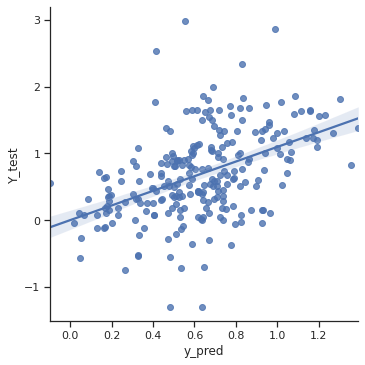

0
(994, 9)
(249, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=45)
Calculating Permutation Importances
249
2-fold :  46.98795180722892
3-fold :  64.65863453815261
5-fold :  79.51807228915662
gmfe :  2.7390206360698612
mfe :  1.371171800718624
bias :  -0.2857022831186544
rmse  0.590242000676203
r2  0.13246226503178649


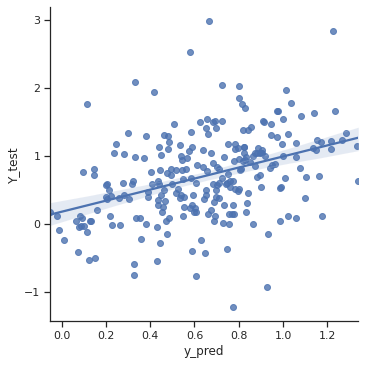

1
(994, 9)
(249, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=8,
                      n_estimators=300, n_jobs=30, random_state=45)
Calculating Permutation Importances
249
2-fold :  44.97991967871486
3-fold :  62.24899598393574
5-fold :  78.714859437751
gmfe :  2.9638959487177576
mfe :  1.4190127476006287
bias :  0.2659616834329226
rmse  0.6422498820031834
r2  0.15561416509992665


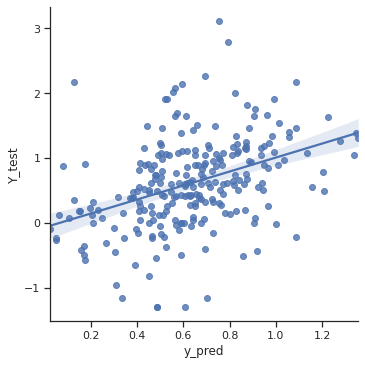

2
(994, 9)
(249, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=4,
                      n_jobs=30, random_state=45)
Calculating Permutation Importances
249
2-fold :  48.59437751004016
3-fold :  70.68273092369478
5-fold :  82.32931726907631
gmfe :  2.587803588502191
mfe :  1.3569887274599104
bias :  -0.3469976610923835
rmse  0.5636926080030702
r2  0.21163888104143092


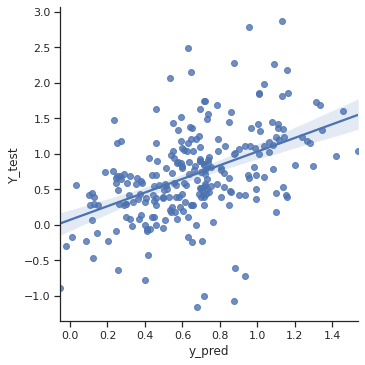

3
(995, 9)
(248, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=8,
                      n_estimators=300, n_jobs=30, random_state=45)
Calculating Permutation Importances
248
2-fold :  45.16129032258064
3-fold :  66.12903225806451
5-fold :  81.45161290322581
gmfe :  2.6836347064021457
mfe :  1.3927341378954612
bias :  0.11341270644770085
rmse  0.5532573022501953
r2  0.15756182308101319


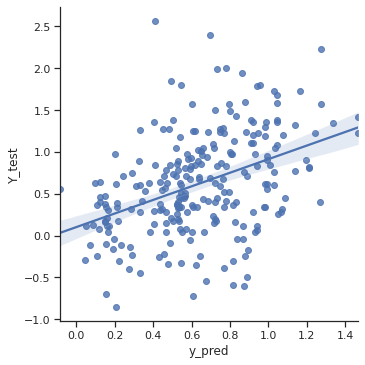

4
(995, 9)
(248, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=8,
                      n_estimators=200, n_jobs=30, random_state=45)
Calculating Permutation Importances
248
2-fold :  44.354838709677416
3-fold :  62.096774193548384
5-fold :  81.04838709677419
gmfe :  2.732749448585105
mfe :  1.436628440599999
bias :  0.7542273472510665
rmse  0.5737562124459217
r2  0.15538427537113964


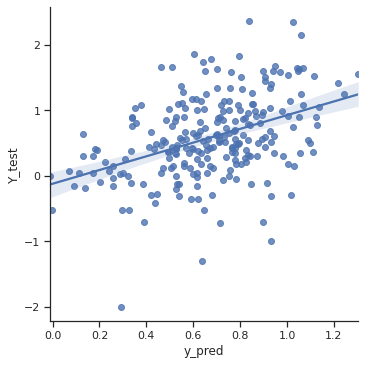

0
(994, 9)
(249, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=46)
Calculating Permutation Importances
249
2-fold :  40.16064257028113
3-fold :  62.24899598393574
5-fold :  78.714859437751
gmfe :  2.917363358108462
mfe :  1.4363307069115128
bias :  0.09063937800809496
rmse  0.6128970631921653
r2  0.1678939570089626


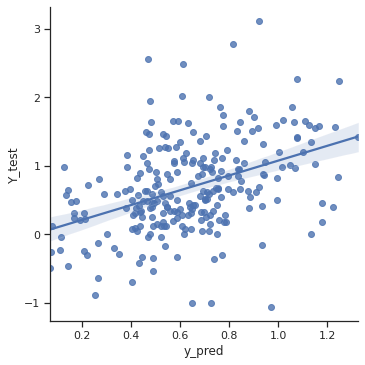

1
(994, 9)
(249, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='log2', min_samples_split=8,
                      n_jobs=30, random_state=46)
Calculating Permutation Importances
249
2-fold :  44.97991967871486
3-fold :  64.2570281124498
5-fold :  82.73092369477911
gmfe :  2.640574368414807
mfe :  1.4012516999913405
bias :  -0.07669604677604802
rmse  0.5515299459887183
r2  0.2173855861443149


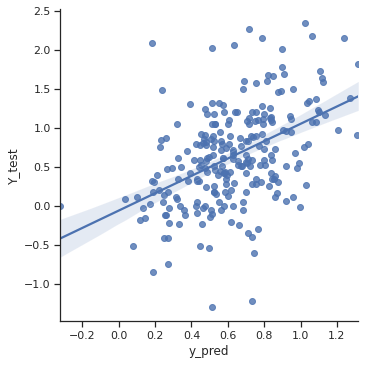

2
(994, 9)
(249, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=8,
                      n_estimators=200, n_jobs=30, random_state=46)
Calculating Permutation Importances
249
2-fold :  51.40562248995983
3-fold :  69.07630522088354
5-fold :  83.53413654618474
gmfe :  2.455198140498761
mfe :  1.3311737063544662
bias :  -0.005589632946250145
rmse  0.5338911224419969
r2  0.2316034288383929
saving model


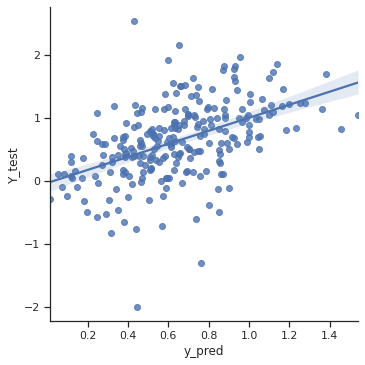

3
(995, 9)
(248, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=8,
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
248
2-fold :  45.16129032258064
3-fold :  61.693548387096776
5-fold :  79.03225806451613
gmfe :  2.940440583950022
mfe :  1.4061174377753605
bias :  -0.3944309422485607
rmse  0.631242185953105
r2  0.15237764441910118


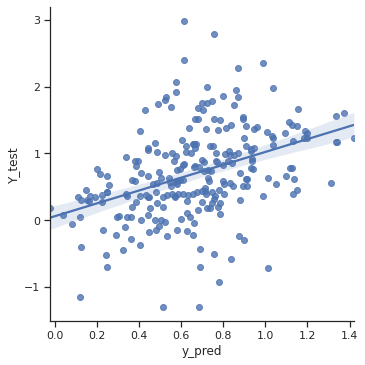

4
(995, 9)
(248, 9)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=8,
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
248
2-fold :  45.16129032258064
3-fold :  64.51612903225806
5-fold :  82.66129032258065
gmfe :  2.675523218570194
mfe :  1.4047697201492606
bias :  0.5987299740622876
rmse  0.5580244676812841
r2  0.15386719712459296


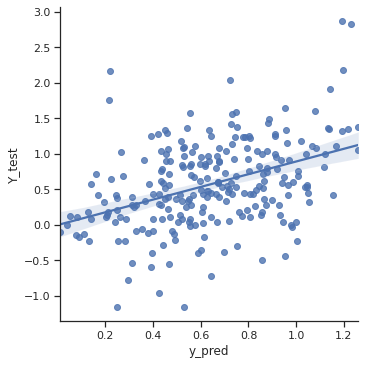

human_thalf
0
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=42)
Calculating Permutation Importances
253
2-fold :  44.66403162055336
3-fold :  65.21739130434783
5-fold :  82.21343873517787
gmfe :  2.724619401672809
mfe :  1.4222239949464974
bias :  0.04130064363669561
rmse  0.5635510021572825
r2  0.19382021445541986
saving model


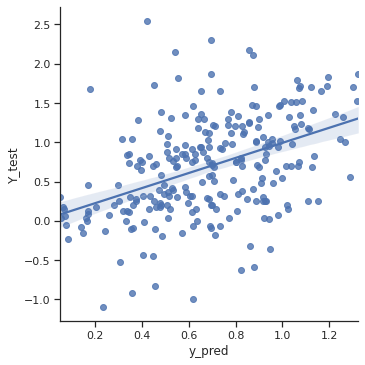

1
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
253
2-fold :  41.50197628458498
3-fold :  67.58893280632411
5-fold :  83.79446640316206
gmfe :  2.6182881980960593
mfe :  1.4042895040538543
bias :  0.1399401988267268
rmse  0.5457998023088337
r2  0.2292053812749888
saving model


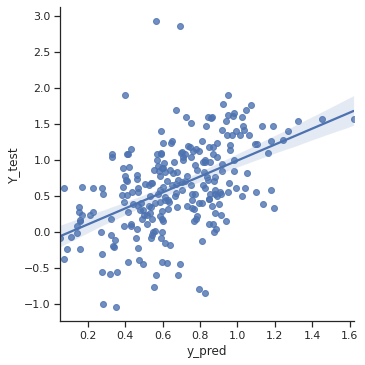

2
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='log2', min_samples_split=8,
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
253
2-fold :  46.24505928853755
3-fold :  69.96047430830039
5-fold :  84.58498023715416
gmfe :  2.533200098880133
mfe :  1.4039849416604822
bias :  0.22262197879830592
rmse  0.5223825158473607
r2  0.19822935095455063
saving model


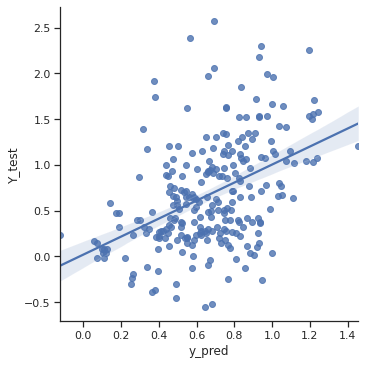

3
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=42)
Calculating Permutation Importances
253
2-fold :  45.8498023715415
3-fold :  63.24110671936759
5-fold :  76.6798418972332
gmfe :  2.938379562260637
mfe :  1.412163335806796
bias :  0.18959403225536153
rmse  0.6381475104801041
r2  0.1673153296946691


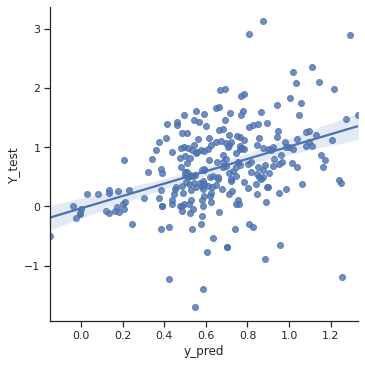

4
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=42)
Calculating Permutation Importances
253
2-fold :  49.01185770750988
3-fold :  71.14624505928853
5-fold :  86.56126482213439
gmfe :  2.376118102288133
mfe :  1.3605691074243922
bias :  0.07402239859986715
rmse  0.49733521706193184
r2  0.2453144902289227
saving model


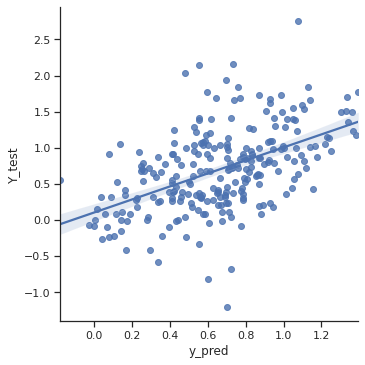

0
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', n_estimators=300,
                      n_jobs=30, random_state=43)
Calculating Permutation Importances
253
2-fold :  43.47826086956522
3-fold :  65.21739130434783
5-fold :  85.7707509881423
gmfe :  2.505225920461106
mfe :  1.4133052260394803
bias :  -0.37680881863172955
rmse  0.5014982348740373
r2  0.20940179635978073


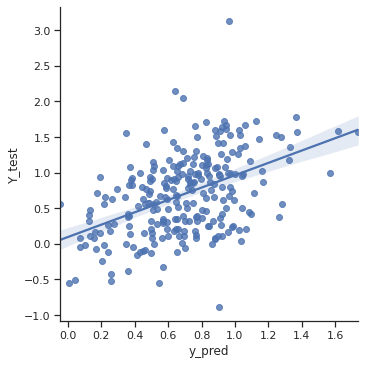

1
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
253
2-fold :  47.03557312252965
3-fold :  67.58893280632411
5-fold :  81.81818181818183
gmfe :  2.7552425695447464
mfe :  1.392034267189952
bias :  0.53079175825412
rmse  0.6029909306492486
r2  0.18261001715770342


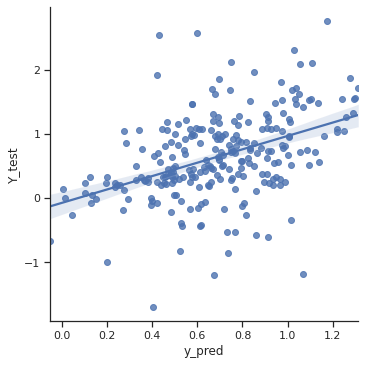

2
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
253
2-fold :  46.24505928853755
3-fold :  64.42687747035573
5-fold :  82.6086956521739
gmfe :  2.6715364602768896
mfe :  1.3985228176518685
bias :  -0.2167518364312888
rmse  0.5591838085775829
r2  0.15297035191690822


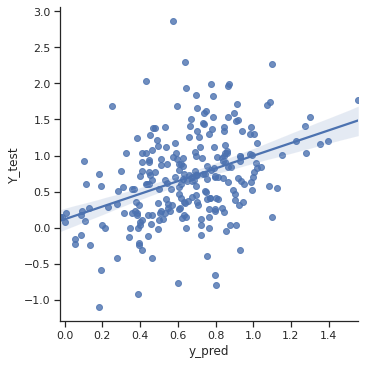

3
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', min_samples_split=8,
                      n_jobs=30, random_state=43)
Calculating Permutation Importances
253
2-fold :  43.873517786561266
3-fold :  67.98418972332016
5-fold :  81.81818181818183
gmfe :  2.639123166651622
mfe :  1.3997104043334851
bias :  0.1855386419545071
rmse  0.5483394927164362
r2  0.21545995122228734


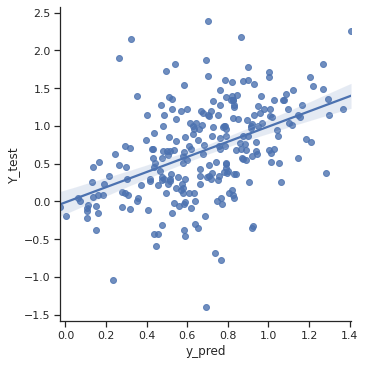

4
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
253
2-fold :  47.03557312252965
3-fold :  67.58893280632411
5-fold :  85.7707509881423
gmfe :  2.598500579319376
mfe :  1.390017782091171
bias :  0.22039815266365848
rmse  0.5536365627280151
r2  0.2762217693486041


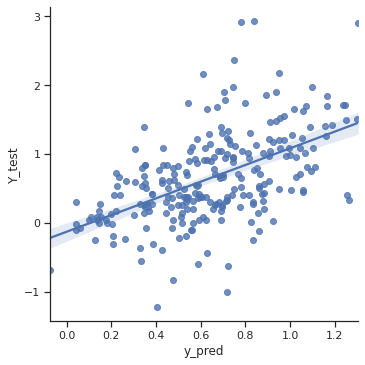

0
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='log2', n_estimators=300,
                      n_jobs=30, random_state=44)
Calculating Permutation Importances
253
2-fold :  46.24505928853755
3-fold :  70.7509881422925
5-fold :  86.95652173913044
gmfe :  2.401488582905255
mfe :  1.3795313337449788
bias :  0.6403055324499771
rmse  0.4893458530388057
r2  0.26003176799774186


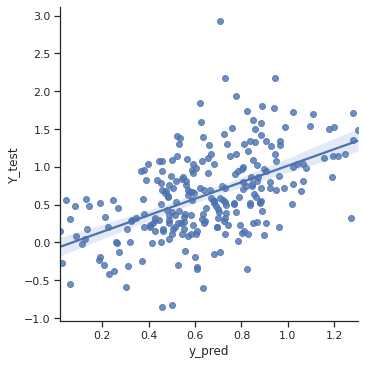

1
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=8,
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
253
2-fold :  42.68774703557312
3-fold :  64.82213438735178
5-fold :  84.18972332015811
gmfe :  2.7193232857169756
mfe :  1.4186708572973856
bias :  0.12457251416542725
rmse  0.5718930955154118
r2  0.22237568206988334


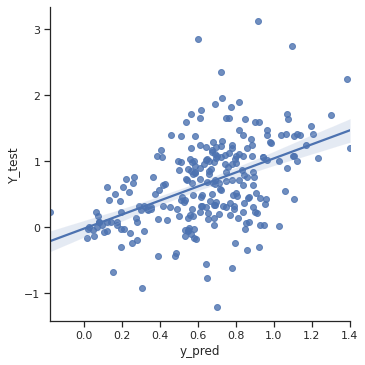

2
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_jobs=30, random_state=44)
Calculating Permutation Importances
253
2-fold :  45.45454545454545
3-fold :  66.00790513833992
5-fold :  85.7707509881423
gmfe :  2.5418457265689214
mfe :  1.3860206484418742
bias :  0.30629941320258336
rmse  0.5368130090581209
r2  0.19862422300451266


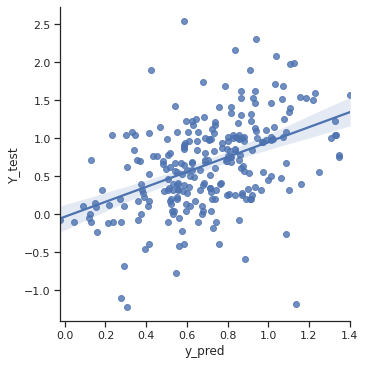

3
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=200,
                      n_jobs=30, random_state=44)
Calculating Permutation Importances
253
2-fold :  41.50197628458498
3-fold :  64.03162055335969
5-fold :  80.63241106719367
gmfe :  2.899512611571244
mfe :  1.4169801720787825
bias :  0.059270952550573686
rmse  0.6126999299473419
r2  0.1382912735206583


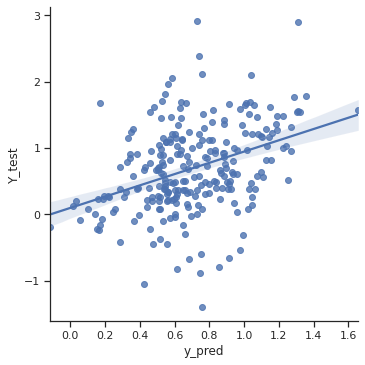

4
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=200,
                      n_jobs=30, random_state=44)
Calculating Permutation Importances
253
2-fold :  45.8498023715415
3-fold :  67.58893280632411
5-fold :  83.399209486166
gmfe :  2.6463299904032045
mfe :  1.4036265148744216
bias :  -0.29973873312002297
rmse  0.563019867516223
r2  0.20323139306970328


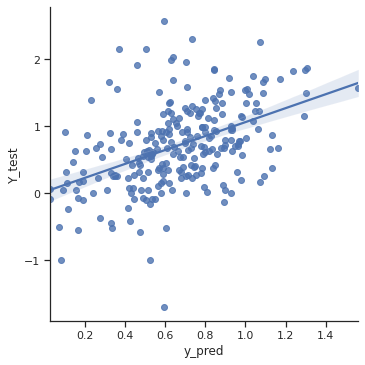

0
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=8,
                      n_estimators=300, n_jobs=30, random_state=45)
Calculating Permutation Importances
253
2-fold :  46.6403162055336
3-fold :  63.63636363636363
5-fold :  81.02766798418972
gmfe :  2.6900725982277063
mfe :  1.3807943616890388
bias :  0.45702747678385736
rmse  0.5689521711419095
r2  0.1715336914058565


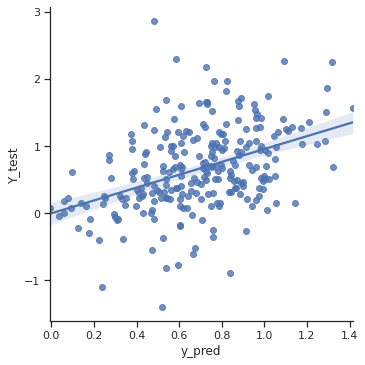

1
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=8,
                      n_jobs=30, random_state=45)
Calculating Permutation Importances
253
2-fold :  44.26877470355731
3-fold :  68.77470355731225
5-fold :  84.58498023715416
gmfe :  2.5236266735255
mfe :  1.3953580281900777
bias :  0.14197104926979343
rmse  0.5086730330672613
r2  0.20592411978445546


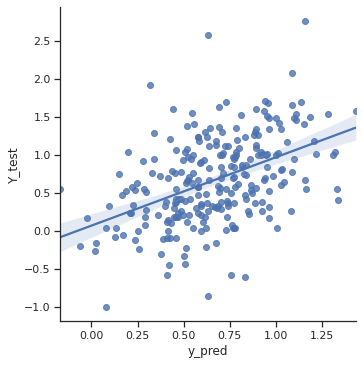

2
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', n_estimators=300,
                      n_jobs=30, random_state=45)
Calculating Permutation Importances
253
2-fold :  47.82608695652174
3-fold :  69.96047430830039
5-fold :  84.18972332015811
gmfe :  2.6550440721171844
mfe :  1.3705889102650777
bias :  -0.1954665000024125
rmse  0.5738766192695224
r2  0.2043015618587214


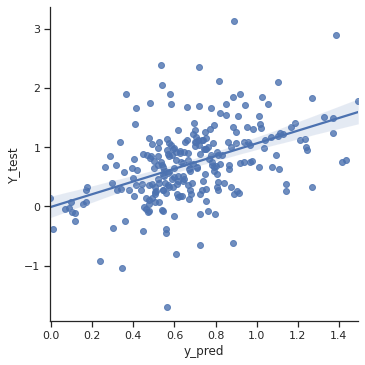

3
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=200,
                      n_jobs=30, random_state=45)
Calculating Permutation Importances
253
2-fold :  45.8498023715415
3-fold :  65.21739130434783
5-fold :  80.63241106719367
gmfe :  2.7108298227530803
mfe :  1.3829811950856037
bias :  0.2956222102776591
rmse  0.5718932976980893
r2  0.22173354426737735


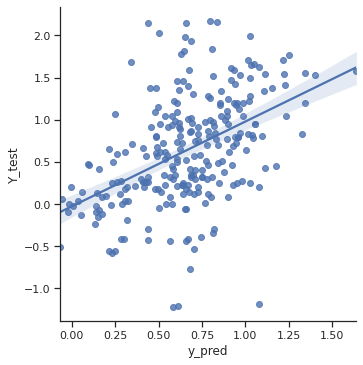

4
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=45)
Calculating Permutation Importances
253
2-fold :  47.03557312252965
3-fold :  67.19367588932806
5-fold :  84.58498023715416
gmfe :  2.542539828610391
mfe :  1.3783542719268567
bias :  0.16951703901904702
rmse  0.5355581460717469
r2  0.25704505870832994


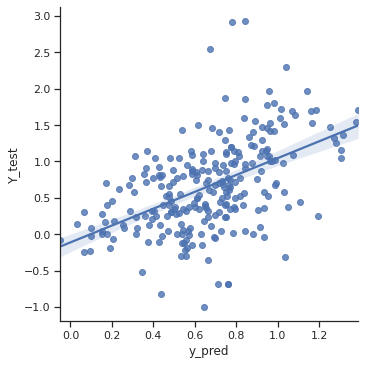

0
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=46)
Calculating Permutation Importances
253
2-fold :  45.059288537549406
3-fold :  64.03162055335969
5-fold :  82.21343873517787
gmfe :  2.6874958656353565
mfe :  1.4339852110011184
bias :  -0.6177061135004314
rmse  0.5596532113128911
r2  0.17779263657380795


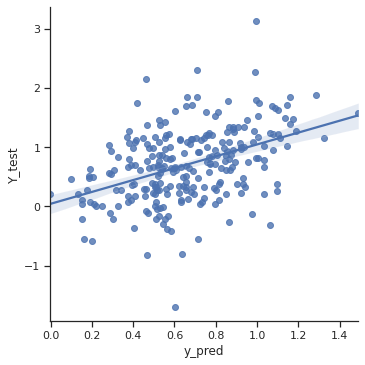

1
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
253
2-fold :  46.6403162055336
3-fold :  71.54150197628458
5-fold :  86.16600790513834
gmfe :  2.4153070172813464
mfe :  1.3684757817453614
bias :  0.28454999658498337
rmse  0.5005358768363616
r2  0.221786205444227


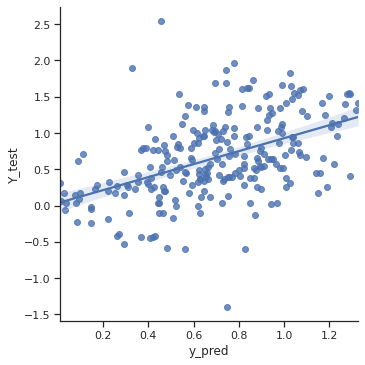

2
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', min_samples_split=8,
                      n_jobs=30, random_state=46)
Calculating Permutation Importances
253
2-fold :  48.616600790513836
3-fold :  69.1699604743083
5-fold :  86.56126482213439
gmfe :  2.49480419788521
mfe :  1.3608486638228523
bias :  0.20571489925518804
rmse  0.5341314739364033
r2  0.22291206508154193


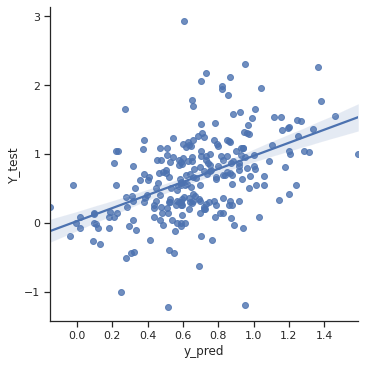

3
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=8,
                      n_estimators=200, n_jobs=30, random_state=46)
Calculating Permutation Importances
253
2-fold :  43.47826086956522
3-fold :  64.03162055335969
5-fold :  81.42292490118577
gmfe :  2.7941563374529528
mfe :  1.422087155529411
bias :  0.4539244658391466
rmse  0.5932189778693946
r2  0.2425727371561186


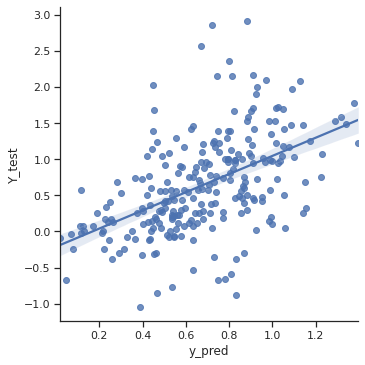

4
(1012, 9)
(253, 9)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
253
2-fold :  44.66403162055336
3-fold :  63.24110671936759
5-fold :  83.00395256916995
gmfe :  2.6920597099936026
mfe :  1.4143186897702436
bias :  0.16861241771187263
rmse  0.5576655083054686
r2  0.23045413521582925


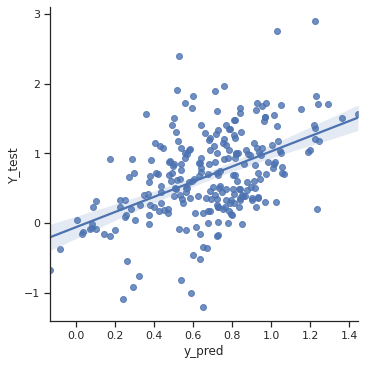

In [24]:
from sklearn.preprocessing import StandardScaler
import pickle
list_of_lists=[]
detail_list_batch=[]
model_parameters_batch=[]


for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]:

    data = human_lombardo_mfp_Mordred_animal
    features = features_animal_columns
    baseline=10.00

    print(endpoint)    
    df = data.dropna(subset=[endpoint]).reset_index(drop=True)

    X = df[features]
    Y = df[endpoint]
    
    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=features)
    
    #Nested Cross Validation    
    for i in range(42, 47):
        
        outercv = KFold(n_splits=5, random_state=i, shuffle=True) 

        for split, (train_index, test_index) in enumerate(outercv.split(X)):
            
            print(split)
            train = df.iloc[train_index]
            X_train= X.iloc[train_index].values
            Y_train= Y.iloc[train_index].values.flatten()

            test = df.iloc[test_index]
            X_test= X.iloc[test_index].values
            Y_test= Y.iloc[test_index].values.flatten()

            print(X_train.shape)
            print(X_test.shape)

            inner_cv = KFold(n_splits=4, random_state=i, shuffle=True) 

            # Create a based model
            regressor = RandomForestRegressor(random_state = i, n_jobs=20)

            # Instantiate the RandomHalving search model
            param_grid = { 
            "n_estimators": [100,200,300],
            "max_features": ["sqrt", "log2"],
            "min_samples_split": [2,4,8],
            "max_depth": [5, 10, 15],    
            "bootstrap": [True, False],
            'n_jobs': [30]
            }

            gsh = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = inner_cv, n_jobs=30, verbose = 1)

            ##MODELS
            print(f"Running ____________________{endpoint} MODELS")

            gsh.fit(X_train, Y_train)
            #print(gsh.best_estimator_)

            #HeldOutTest
            classifier = gsh.best_estimator_
            print(classifier)
            
            row=[endpoint, i, split, classifier.n_estimators, classifier.max_features,
                classifier.min_samples_split, classifier.max_depth, classifier.bootstrap]
            model_parameters_batch.append(row)
            
            
            classifier.fit(X_train, Y_train)

            print("Calculating Permutation Importances")  
            y_pred =  classifier.predict(X_test)     
            print(len(y_pred))

            fold_2= count(y_pred, Y_test, 0.5, 2, endpoint)
            fold_3= count(y_pred, Y_test, 1/3, 3, endpoint)
            fold_5= count(y_pred, Y_test, 1/5, 5, endpoint)
            gmfe = calc_gmfe(y_pred, Y_test, endpoint)
            mfe = median_fold_change_error(y_pred, Y_test, endpoint)
            bias = calc_bias(y_pred, Y_test, endpoint)

            print("2-fold : ", fold_2)
            print("3-fold : ", fold_3)
            print("5-fold : ", fold_5)
            print("gmfe : ", gmfe)
            print("mfe : ", mfe)
            print("bias : ", bias)

            rmse = sqrt(mean_squared_error(Y_test, y_pred))
            print('rmse ',rmse)
            r2 = r2_score(Y_test, y_pred)
            print('r2 ',r2)

            if (gmfe<baseline):
                # save
                print("saving model")
                baseline=gmfe
                pickle.dump(classifier, open(f"log_{endpoint}_withanimaldata_real_and_artificial_only_model.sav",  'wb'))

            sns.set_theme(style="ticks")
            df_plot=pd.DataFrame({"y_pred":y_pred, "Y_test":Y_test})
            sns.lmplot(data=df_plot, x="y_pred", y="Y_test")
            plt.show()

            row=["HeldOut",  endpoint, i, split, fold_2, fold_3, fold_5, gmfe, mfe, bias, rmse, r2]
            list_of_lists.append(row)
            
            #combine results
            for smiles_r, pred, true in zip(test.smiles_r, y_pred, Y_test):
                detail_list_batch.append([endpoint, i, split, smiles_r, pred, true])


In [25]:
model_parameters= pd.DataFrame(model_parameters_batch,columns=["endpoint", "random_state", 
                                                            "split", "n_estimators", "max_features",
                "min_samples_split", "max_depth", "bootstrap"])
model_parameters

endpoint  random_state  split  n_estimators max_features  \
0    human_VDss_L_kg            42      0           300         sqrt   
1    human_VDss_L_kg            42      1           300         log2   
2    human_VDss_L_kg            42      2           100         sqrt   
3    human_VDss_L_kg            42      3           300         sqrt   
4    human_VDss_L_kg            42      4           300         sqrt   
..               ...           ...    ...           ...          ...   
120      human_thalf            46      0           200         sqrt   
121      human_thalf            46      1           300         sqrt   
122      human_thalf            46      2           100         log2   
123      human_thalf            46      3           200         sqrt   
124      human_thalf            46      4           100         log2   

     min_samples_split  max_depth  bootstrap  
0                    2         15       True  
1                    2          5      False  
2                    8         10       True  
3                    2         15       True  
4                    2         10       True  
..                 ...        ...        ...  
120                  4         15       True  
121                  4         15       True  
122                  8         15       True  
123                  8         15       True  
124                  2         15       True  

[125 rows x 8 columns]

In [26]:
detail_list = pd.DataFrame(detail_list_batch,columns=["endpoint", "random_state", 
                                                           "split", "smiles_r", "pred", "true"])
detail_list["key"] =  detail_list["endpoint"].astype(str) + detail_list["smiles_r"].astype(str) + detail_list["random_state"].astype(str)+ detail_list["split"].astype(str)
detail_list

endpoint  random_state  split  \
0      human_VDss_L_kg            42      0   
1      human_VDss_L_kg            42      0   
2      human_VDss_L_kg            42      0   
3      human_VDss_L_kg            42      0   
4      human_VDss_L_kg            42      0   
...                ...           ...    ...   
29580      human_thalf            46      4   
29581      human_thalf            46      4   
29582      human_thalf            46      4   
29583      human_thalf            46      4   
29584      human_thalf            46      4   

                                                smiles_r      pred      true  \
0      C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...  0.455568  0.633468   
1      C=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N)nc(N)c3n2)cc1)... -0.117929 -0.154902   
2      C=CC1=C(C(=O)[O-])[NH+]2C(=O)C(=NC(=O)C(NOCC(=... -0.654006 -0.619789   
3                         C=CCc1ccccc1OCC(O)C[NH2+]C(C)C  0.332914  0.505150   
4      C=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H](Oc2ncc(OC)c3c...  0.058298  0.442480   
...                                                  ...       ...       ...   
29580  [NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-])c(Br)c1)NC...  0.849499  0.397940   
29581                 [NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21  0.582679  1.064458   
29582                [O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1  0.727144 -0.173925   
29583  [O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-])c([O-])c3...  0.777966  0.000000   
29584                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  0.932625  0.359835   

                                                     key  
0      human_VDss_L_kgC#C[C@]1(O)CC[C@H]2[C@@H]3CCc4c...  
1      human_VDss_L_kgC=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N...  
2      human_VDss_L_kgC=CC1=C(C(=O)[O-])[NH+]2C(=O)C(...  
3       human_VDss_L_kgC=CCc1ccccc1OCC(O)C[NH2+]C(C)C420  
4      human_VDss_L_kgC=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H...  
...                                                  ...  
29580  human_thalf[NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-]...  
29581   human_thalf[NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21464  
29582  human_thalf[O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1464  
29583  human_thalf[O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-...  
29584  human_thalfc1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1464  

[29585 rows x 7 columns]

In [27]:
results = pd.DataFrame(list_of_lists, columns=["HeldOut", "endpoint", "random_state", "split", "fold_2", "fold_3", "fold_5", "gmfe", "mfe", "bias", "rmse", "r2"])
results

HeldOut         endpoint  random_state  split     fold_2     fold_3  \
0    HeldOut  human_VDss_L_kg            42      0  50.800000  71.200000   
1    HeldOut  human_VDss_L_kg            42      1  49.200000  70.000000   
2    HeldOut  human_VDss_L_kg            42      2  53.600000  69.600000   
3    HeldOut  human_VDss_L_kg            42      3  54.000000  69.600000   
4    HeldOut  human_VDss_L_kg            42      4  51.405622  74.297189   
..       ...              ...           ...    ...        ...        ...   
120  HeldOut      human_thalf            46      0  45.059289  64.031621   
121  HeldOut      human_thalf            46      1  46.640316  71.541502   
122  HeldOut      human_thalf            46      2  48.616601  69.169960   
123  HeldOut      human_thalf            46      3  43.478261  64.031621   
124  HeldOut      human_thalf            46      4  44.664032  63.241107   

        fold_5      gmfe       mfe      bias      rmse        r2  
0    85.600000  2.323934  1.338854  0.043682  0.485640  0.453383  
1    84.000000  2.323033  1.365410  0.077308  0.464313  0.422551  
2    81.600000  2.444050  1.308517  0.004117  0.524441  0.366819  
3    87.600000  2.264952  1.303229 -0.002097  0.468937  0.474925  
4    88.755020  2.277079  1.335839  0.023639  0.462964  0.444473  
..         ...       ...       ...       ...       ...       ...  
120  82.213439  2.687496  1.433985 -0.617706  0.559653  0.177793  
121  86.166008  2.415307  1.368476  0.284550  0.500536  0.221786  
122  86.561265  2.494804  1.360849  0.205715  0.534131  0.222912  
123  81.422925  2.794156  1.422087  0.453924  0.593219  0.242573  
124  83.003953  2.692060  1.414319  0.168612  0.557666  0.230454  

[125 rows x 12 columns]

In [28]:
model_parameters.to_csv("model_parameters_Prediction_human_from_animal_artificial_and_real_only.csv", index=False)

In [29]:
detail_list.to_csv("detail_list_Prediction_human_from_animal_artificial_and_real_only.csv", index=False)

In [30]:
results.to_csv("Prediction_human_from_animal_artificial_and_real_only.csv", index=False)

In [31]:
import pandas as pd
results= pd.read_csv("Prediction_human_from_animal_artificial_and_real_only.csv")
results.groupby("endpoint").mean().reset_index().to_csv("human_from_animal_artificial_and_real_only.csv", index=False)
results.groupby("endpoint").mean()

random_state  split     fold_2     fold_3     fold_5  \
endpoint                                                                   
human_CL_mL_min_kg          44.0    2.0  47.039336  68.009424  82.653879   
human_VDss_L_kg             44.0    2.0  52.185960  71.562474  85.942040   
human_fup                   44.0    2.0  54.902338  67.690909  78.292597   
human_mrt                   44.0    2.0  45.744462  65.180658  81.189662   
human_thalf                 44.0    2.0  45.470356  66.798419  83.478261   

                        gmfe       mfe      bias      rmse        r2  
endpoint                                                              
human_CL_mL_min_kg  2.653966  1.377658 -0.228485  0.572669  0.216208  
human_VDss_L_kg     2.317472  1.328456  0.021601  0.480747  0.433260  
human_fup           2.771785  1.292742  0.036667  0.223727  0.564279  
human_mrt           2.722742  1.393497  0.068953  0.579180  0.178943  
human_thalf         2.630987  1.396378  0.128205  0.552432  0.209966

In [32]:
# load
loaded_rf = pickle.load(open("log_human_VDss_L_kg_withanimaldata_real_and_artificial_only_model.sav", 'rb'))